# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:09<00:00, 6.48KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

#sudo python3 -m pip install -U matplotlib==2.0.2

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


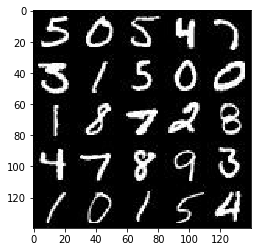

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

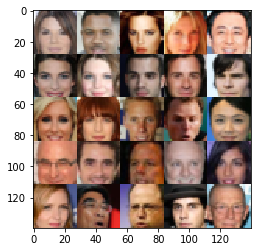

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name = 'inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    Learning_rate = tf.placeholder(tf.float32, None, name='Learning_rate')

    return inputs_real, inputs_z, Learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/lib/python3.5/runpy.py", line 184, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/dist-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/dist-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/dist-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/usr/lo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        strides = 2
        k_size = 5
        alpha = 0.2
        
        # Input layer is 28x28x3
        conv_layer_1 = tf.layers.conv2d(images, 64, kernel_size=k_size,
                                        strides=strides, padding='same', use_bias=False, activation=None)
        conv_layer_1 = tf.maximum(conv_layer_1, alpha*conv_layer_1)# Leaky ReLU
        # 14x14x64 here
        
        conv_layer_2 = tf.layers.conv2d(conv_layer_1, 128, kernel_size=k_size,
                                        strides=strides, padding='same', use_bias=False, activation=None)
        conv_layer_2 = tf.layers.batch_normalization(conv_layer_2, training=True)
        conv_layer_2 = tf.maximum(conv_layer_2, alpha*conv_layer_2)# Leaky ReLU
        # 7x7x128 here
        
        conv_layer_3 = tf.layers.conv2d(conv_layer_2, 256, kernel_size=k_size,
                                        strides=strides, padding='same', use_bias=False, activation=None)
        conv_layer_3 = tf.layers.batch_normalization(conv_layer_3, training=True)
        conv_layer_3 = tf.maximum(conv_layer_3, alpha*conv_layer_3)# Leaky ReLU
        # 4x4x256 now
        
        # Flatten it
        flat = tf.reshape(conv_layer_3,[-1, 4*4*256])
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        strides = 2
        k_size = 5
        alpha = 0.2
        
        # Input layer is 28x28x3
        conv_layer_1 = tf.layers.conv2d(images, 64, kernel_size=k_size,
                                        strides=strides, padding='same', use_bias=False, activation=None)
        conv_layer_1 = tf.maximum(conv_layer_1, alpha*conv_layer_1)# Leaky ReLU
        # 14x14x64 here
        
        conv_layer_2 = tf.layers.conv2d(conv_layer_1, 128, kernel_size=k_size,
                                        strides=strides, padding='same', use_bias=False, activation=None)
        conv_layer_2 = tf.layers.batch_normalization(conv_layer_2, training=True)
        conv_layer_2 = tf.maximum(conv_layer_2, alpha*conv_layer_2)# Leaky ReLU
        # 7x7x128 here
        
        # Flatten it
        flat = tf.reshape(conv_layer_2,[-1, 7*7*128])
        logits = tf.layers.dense(flat, 1)
        out = tf.nn.sigmoid(logits)
        

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse = not is_train):

        strides = 2
        k_size = 5
        alpha = 0.2
        
        # First fully connected layer
        x = tf.layers.dense(z, 7*7*128)

        # Reshape it to start the convolutional stack
        conv_layer_1 = tf.reshape(x, [-1,7,7,128])
        conv_layer_1 = tf.layers.batch_normalization(conv_layer_1, training=is_train)
        conv_layer_1 = tf.maximum(conv_layer_1, alpha*conv_layer_1)# Leaky ReLU
        # 7x7x128 now
        
        conv_layer_2 = tf.layers.conv2d_transpose(conv_layer_1, 64, kernel_size=k_size, 
                                                  strides=strides, padding='same', use_bias=False, activation=None)
        conv_layer_2 = tf.layers.batch_normalization(conv_layer_2, training=is_train)
        conv_layer_2 = tf.maximum(conv_layer_2, alpha*conv_layer_2)# Leaky ReLU
        # 14x14x64 now
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(conv_layer_2, out_channel_dim, kernel_size=k_size,
                                            strides=strides, padding='same', use_bias=False, activation=None)
        
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    
    smooth = 0.1
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    if data_image_mode == 'RGB':
        out_channel_dim = 3
    elif data_image_mode == 'L':
        out_channel_dim = 1
    
    #tf.reset_default_graph()
    input_real, input_z, Learning_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_opt, g_opt = model_opt(d_loss, g_loss, Learning_rate, beta1)
    
    
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0
    print_every=10
    show_every=100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                #rescale batch_image data from [-0.5, 0.5] to [-1, 1] as we are using tanh activation function
                batch_images *= 2
                
                # TODO: Train Model
                steps += 1
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, Learning_rate: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images, Learning_rate: learning_rate})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images, Learning_rate: learning_rate})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % show_every == 0:
                    show_generator_output(sess, 16, input_z, out_channel_dim, data_image_mode)

        saver.save(sess, './checkpoints/generator.ckpt')
 

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6881... Generator Loss: 1.5039
Epoch 1/2... Discriminator Loss: 1.2838... Generator Loss: 1.0481
Epoch 1/2... Discriminator Loss: 1.1187... Generator Loss: 1.2550
Epoch 1/2... Discriminator Loss: 0.9979... Generator Loss: 0.9191
Epoch 1/2... Discriminator Loss: 0.9793... Generator Loss: 1.6618
Epoch 1/2... Discriminator Loss: 0.6688... Generator Loss: 1.7067
Epoch 1/2... Discriminator Loss: 1.3327... Generator Loss: 0.5285
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 0.7588
Epoch 1/2... Discriminator Loss: 1.0584... Generator Loss: 1.1885
Epoch 1/2... Discriminator Loss: 1.1139... Generator Loss: 0.8531


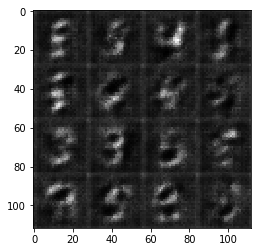

Epoch 1/2... Discriminator Loss: 1.0922... Generator Loss: 1.5836
Epoch 1/2... Discriminator Loss: 1.0523... Generator Loss: 0.9087
Epoch 1/2... Discriminator Loss: 1.0281... Generator Loss: 1.3100
Epoch 1/2... Discriminator Loss: 1.2592... Generator Loss: 0.6358
Epoch 1/2... Discriminator Loss: 1.0300... Generator Loss: 1.6234
Epoch 1/2... Discriminator Loss: 1.0945... Generator Loss: 0.9765
Epoch 1/2... Discriminator Loss: 1.0472... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 1.2163... Generator Loss: 1.9325
Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 1.3115
Epoch 1/2... Discriminator Loss: 1.0653... Generator Loss: 1.1079


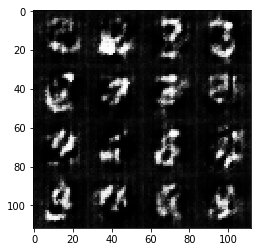

Epoch 1/2... Discriminator Loss: 1.2739... Generator Loss: 0.6692
Epoch 1/2... Discriminator Loss: 1.0223... Generator Loss: 1.3079
Epoch 1/2... Discriminator Loss: 1.0606... Generator Loss: 0.9502
Epoch 1/2... Discriminator Loss: 1.0429... Generator Loss: 1.4417
Epoch 1/2... Discriminator Loss: 1.1044... Generator Loss: 1.1312
Epoch 1/2... Discriminator Loss: 1.0155... Generator Loss: 0.8346
Epoch 1/2... Discriminator Loss: 1.0616... Generator Loss: 1.4626
Epoch 1/2... Discriminator Loss: 1.1180... Generator Loss: 0.7531
Epoch 1/2... Discriminator Loss: 0.9442... Generator Loss: 1.3168
Epoch 1/2... Discriminator Loss: 1.3297... Generator Loss: 2.2753


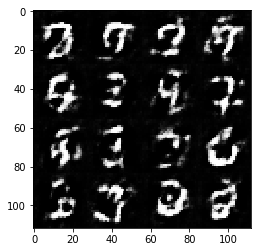

Epoch 1/2... Discriminator Loss: 1.0466... Generator Loss: 0.8461
Epoch 1/2... Discriminator Loss: 0.9520... Generator Loss: 1.5095
Epoch 1/2... Discriminator Loss: 0.8714... Generator Loss: 1.8718
Epoch 1/2... Discriminator Loss: 1.0756... Generator Loss: 0.7947
Epoch 1/2... Discriminator Loss: 0.9905... Generator Loss: 0.8920
Epoch 1/2... Discriminator Loss: 0.9193... Generator Loss: 1.2770
Epoch 1/2... Discriminator Loss: 0.9170... Generator Loss: 1.1771
Epoch 1/2... Discriminator Loss: 0.8244... Generator Loss: 1.2118
Epoch 1/2... Discriminator Loss: 0.8812... Generator Loss: 1.3288
Epoch 1/2... Discriminator Loss: 0.8730... Generator Loss: 1.4074


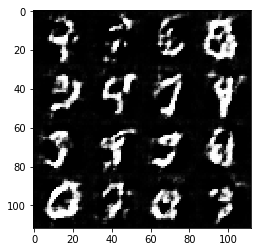

Epoch 1/2... Discriminator Loss: 1.0053... Generator Loss: 0.8665
Epoch 1/2... Discriminator Loss: 0.9997... Generator Loss: 1.9945
Epoch 1/2... Discriminator Loss: 0.9328... Generator Loss: 1.2991
Epoch 1/2... Discriminator Loss: 0.8403... Generator Loss: 1.2936
Epoch 1/2... Discriminator Loss: 0.9506... Generator Loss: 1.0197
Epoch 1/2... Discriminator Loss: 1.0570... Generator Loss: 0.7747
Epoch 1/2... Discriminator Loss: 0.9249... Generator Loss: 1.6824
Epoch 1/2... Discriminator Loss: 0.8023... Generator Loss: 1.4667
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 0.8038
Epoch 1/2... Discriminator Loss: 1.2434... Generator Loss: 0.5981


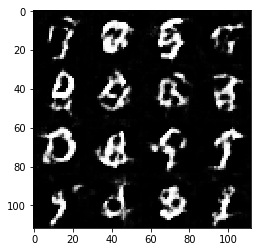

Epoch 1/2... Discriminator Loss: 0.8590... Generator Loss: 1.5953
Epoch 1/2... Discriminator Loss: 0.9253... Generator Loss: 1.1132
Epoch 1/2... Discriminator Loss: 1.3385... Generator Loss: 0.5405
Epoch 1/2... Discriminator Loss: 0.8444... Generator Loss: 1.0464
Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 0.8531
Epoch 1/2... Discriminator Loss: 1.0038... Generator Loss: 1.9711
Epoch 1/2... Discriminator Loss: 0.8768... Generator Loss: 1.1199
Epoch 1/2... Discriminator Loss: 0.9946... Generator Loss: 0.9242
Epoch 1/2... Discriminator Loss: 0.9073... Generator Loss: 2.1259
Epoch 1/2... Discriminator Loss: 1.1976... Generator Loss: 0.6938


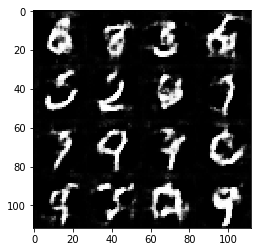

Epoch 1/2... Discriminator Loss: 0.8840... Generator Loss: 1.3281
Epoch 1/2... Discriminator Loss: 0.9147... Generator Loss: 1.2923
Epoch 1/2... Discriminator Loss: 0.9182... Generator Loss: 1.3895
Epoch 1/2... Discriminator Loss: 1.0067... Generator Loss: 1.7395
Epoch 1/2... Discriminator Loss: 1.0701... Generator Loss: 0.9617
Epoch 1/2... Discriminator Loss: 1.1375... Generator Loss: 1.7930
Epoch 1/2... Discriminator Loss: 1.0618... Generator Loss: 1.0425
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 0.9209
Epoch 1/2... Discriminator Loss: 1.2805... Generator Loss: 2.4200
Epoch 1/2... Discriminator Loss: 0.9512... Generator Loss: 0.9927


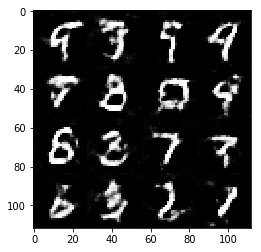

Epoch 1/2... Discriminator Loss: 1.0843... Generator Loss: 2.0045
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 1.3893
Epoch 1/2... Discriminator Loss: 1.0381... Generator Loss: 0.9624
Epoch 1/2... Discriminator Loss: 1.0480... Generator Loss: 1.8068
Epoch 1/2... Discriminator Loss: 0.9181... Generator Loss: 1.3486
Epoch 1/2... Discriminator Loss: 1.2679... Generator Loss: 0.5753
Epoch 1/2... Discriminator Loss: 1.0917... Generator Loss: 1.4642
Epoch 1/2... Discriminator Loss: 1.2216... Generator Loss: 0.6527
Epoch 1/2... Discriminator Loss: 0.9542... Generator Loss: 0.9614
Epoch 1/2... Discriminator Loss: 0.9348... Generator Loss: 1.1671


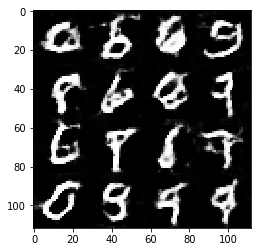

Epoch 1/2... Discriminator Loss: 1.1255... Generator Loss: 0.9726
Epoch 1/2... Discriminator Loss: 1.0551... Generator Loss: 1.5149
Epoch 1/2... Discriminator Loss: 1.2625... Generator Loss: 0.7017
Epoch 1/2... Discriminator Loss: 1.6838... Generator Loss: 0.3413
Epoch 1/2... Discriminator Loss: 1.0436... Generator Loss: 1.1267
Epoch 1/2... Discriminator Loss: 0.9474... Generator Loss: 0.9544
Epoch 1/2... Discriminator Loss: 1.0285... Generator Loss: 2.0556
Epoch 1/2... Discriminator Loss: 0.9795... Generator Loss: 1.0055
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 1.4583
Epoch 1/2... Discriminator Loss: 1.0405... Generator Loss: 1.0087


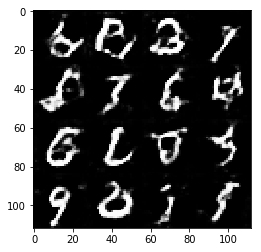

Epoch 1/2... Discriminator Loss: 0.9530... Generator Loss: 1.3061
Epoch 1/2... Discriminator Loss: 1.4854... Generator Loss: 1.7822
Epoch 1/2... Discriminator Loss: 1.1065... Generator Loss: 1.3521
Epoch 1/2... Discriminator Loss: 1.0389... Generator Loss: 1.1612
Epoch 1/2... Discriminator Loss: 0.9642... Generator Loss: 1.2805
Epoch 1/2... Discriminator Loss: 1.0181... Generator Loss: 0.9338
Epoch 1/2... Discriminator Loss: 1.0246... Generator Loss: 1.0473
Epoch 1/2... Discriminator Loss: 1.2574... Generator Loss: 0.6573
Epoch 1/2... Discriminator Loss: 1.1044... Generator Loss: 1.0133
Epoch 1/2... Discriminator Loss: 1.3809... Generator Loss: 2.2684


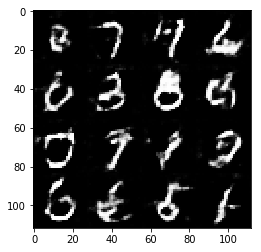

Epoch 1/2... Discriminator Loss: 1.0426... Generator Loss: 1.0551
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 0.7360
Epoch 1/2... Discriminator Loss: 1.0192... Generator Loss: 0.9932
Epoch 1/2... Discriminator Loss: 1.0499... Generator Loss: 0.9091
Epoch 1/2... Discriminator Loss: 0.9718... Generator Loss: 1.5277
Epoch 1/2... Discriminator Loss: 1.0850... Generator Loss: 1.6143
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 0.6313
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 0.7366
Epoch 1/2... Discriminator Loss: 1.1553... Generator Loss: 0.6561
Epoch 1/2... Discriminator Loss: 1.3600... Generator Loss: 2.5094


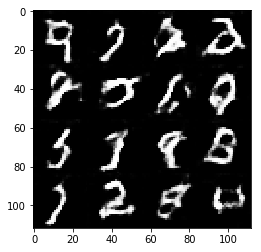

Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 0.6234
Epoch 1/2... Discriminator Loss: 1.1829... Generator Loss: 0.8616
Epoch 1/2... Discriminator Loss: 1.0466... Generator Loss: 0.9322
Epoch 1/2... Discriminator Loss: 0.9387... Generator Loss: 0.9290
Epoch 1/2... Discriminator Loss: 1.1480... Generator Loss: 1.2447
Epoch 1/2... Discriminator Loss: 0.9689... Generator Loss: 1.2472
Epoch 1/2... Discriminator Loss: 2.1361... Generator Loss: 0.2329
Epoch 1/2... Discriminator Loss: 1.1258... Generator Loss: 0.8749
Epoch 1/2... Discriminator Loss: 1.0189... Generator Loss: 1.0845
Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 1.3114


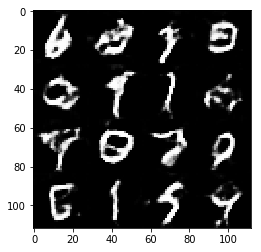

Epoch 1/2... Discriminator Loss: 1.0185... Generator Loss: 1.1189
Epoch 1/2... Discriminator Loss: 0.9859... Generator Loss: 0.9072
Epoch 1/2... Discriminator Loss: 0.9499... Generator Loss: 1.0301
Epoch 1/2... Discriminator Loss: 1.5241... Generator Loss: 0.4195
Epoch 1/2... Discriminator Loss: 1.3156... Generator Loss: 0.6033
Epoch 1/2... Discriminator Loss: 0.9890... Generator Loss: 1.0995
Epoch 1/2... Discriminator Loss: 0.8983... Generator Loss: 1.2335
Epoch 1/2... Discriminator Loss: 1.1996... Generator Loss: 0.6869
Epoch 1/2... Discriminator Loss: 0.9088... Generator Loss: 1.3214
Epoch 1/2... Discriminator Loss: 1.0817... Generator Loss: 1.7050


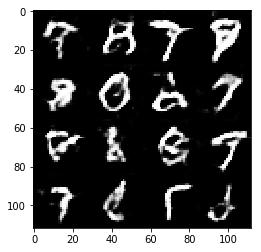

Epoch 1/2... Discriminator Loss: 1.0250... Generator Loss: 0.8658
Epoch 1/2... Discriminator Loss: 1.3509... Generator Loss: 0.4999
Epoch 1/2... Discriminator Loss: 1.3441... Generator Loss: 0.5764
Epoch 1/2... Discriminator Loss: 1.6648... Generator Loss: 0.5037
Epoch 1/2... Discriminator Loss: 1.3661... Generator Loss: 0.5214
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 0.9936
Epoch 1/2... Discriminator Loss: 0.9173... Generator Loss: 1.0344
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.6996
Epoch 1/2... Discriminator Loss: 0.9732... Generator Loss: 0.9060
Epoch 1/2... Discriminator Loss: 1.3942... Generator Loss: 0.5356


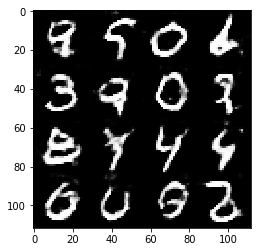

Epoch 1/2... Discriminator Loss: 1.0986... Generator Loss: 1.1711
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 1.4766
Epoch 1/2... Discriminator Loss: 0.8757... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 1.0711... Generator Loss: 0.7649
Epoch 1/2... Discriminator Loss: 0.9911... Generator Loss: 1.0139
Epoch 1/2... Discriminator Loss: 0.8579... Generator Loss: 1.0858
Epoch 1/2... Discriminator Loss: 2.0729... Generator Loss: 0.2380
Epoch 1/2... Discriminator Loss: 0.9479... Generator Loss: 1.0665
Epoch 1/2... Discriminator Loss: 1.0479... Generator Loss: 1.5815
Epoch 1/2... Discriminator Loss: 1.0948... Generator Loss: 0.7660


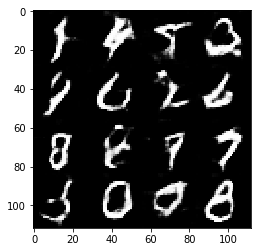

Epoch 1/2... Discriminator Loss: 0.9821... Generator Loss: 1.1685
Epoch 1/2... Discriminator Loss: 0.9483... Generator Loss: 1.4035
Epoch 1/2... Discriminator Loss: 1.0228... Generator Loss: 1.3680
Epoch 1/2... Discriminator Loss: 1.3628... Generator Loss: 0.5356
Epoch 1/2... Discriminator Loss: 0.8864... Generator Loss: 1.0886
Epoch 1/2... Discriminator Loss: 0.9796... Generator Loss: 0.9795
Epoch 1/2... Discriminator Loss: 0.9646... Generator Loss: 0.8757
Epoch 1/2... Discriminator Loss: 1.1709... Generator Loss: 0.6386
Epoch 1/2... Discriminator Loss: 0.8849... Generator Loss: 1.0743
Epoch 1/2... Discriminator Loss: 1.0224... Generator Loss: 1.8318


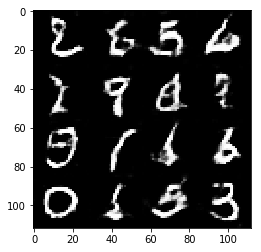

Epoch 1/2... Discriminator Loss: 1.0233... Generator Loss: 1.2502
Epoch 1/2... Discriminator Loss: 1.1709... Generator Loss: 0.6661
Epoch 1/2... Discriminator Loss: 0.9466... Generator Loss: 1.0561
Epoch 1/2... Discriminator Loss: 0.8147... Generator Loss: 1.2552
Epoch 1/2... Discriminator Loss: 1.0774... Generator Loss: 0.8660
Epoch 1/2... Discriminator Loss: 0.9172... Generator Loss: 1.4093
Epoch 1/2... Discriminator Loss: 0.9031... Generator Loss: 1.1406
Epoch 1/2... Discriminator Loss: 0.9820... Generator Loss: 0.9618
Epoch 1/2... Discriminator Loss: 1.5721... Generator Loss: 2.7606
Epoch 1/2... Discriminator Loss: 0.8854... Generator Loss: 1.5074


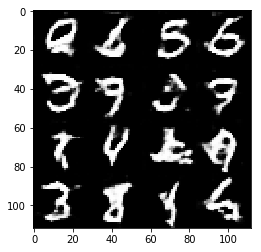

Epoch 1/2... Discriminator Loss: 0.9680... Generator Loss: 1.3233
Epoch 1/2... Discriminator Loss: 1.2380... Generator Loss: 0.6369
Epoch 1/2... Discriminator Loss: 1.9721... Generator Loss: 0.2944
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 1.0400
Epoch 1/2... Discriminator Loss: 0.9530... Generator Loss: 1.0568
Epoch 1/2... Discriminator Loss: 1.4138... Generator Loss: 0.5221
Epoch 1/2... Discriminator Loss: 0.9491... Generator Loss: 1.1531
Epoch 1/2... Discriminator Loss: 0.8938... Generator Loss: 1.1302
Epoch 1/2... Discriminator Loss: 0.9269... Generator Loss: 1.3678
Epoch 1/2... Discriminator Loss: 1.0837... Generator Loss: 0.7979


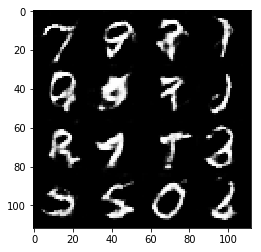

Epoch 1/2... Discriminator Loss: 1.0491... Generator Loss: 1.9575
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 1.6533
Epoch 1/2... Discriminator Loss: 0.9578... Generator Loss: 1.0168
Epoch 1/2... Discriminator Loss: 1.2331... Generator Loss: 0.6125
Epoch 1/2... Discriminator Loss: 1.3973... Generator Loss: 0.6152
Epoch 1/2... Discriminator Loss: 1.0452... Generator Loss: 1.3143
Epoch 1/2... Discriminator Loss: 1.2417... Generator Loss: 2.0130
Epoch 2/2... Discriminator Loss: 0.9301... Generator Loss: 1.0154
Epoch 2/2... Discriminator Loss: 0.8738... Generator Loss: 1.4172
Epoch 2/2... Discriminator Loss: 1.1993... Generator Loss: 0.6888


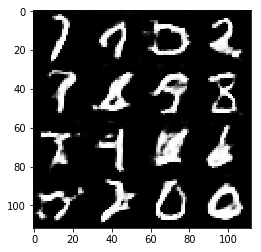

Epoch 2/2... Discriminator Loss: 1.0859... Generator Loss: 0.8465
Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 1.6615
Epoch 2/2... Discriminator Loss: 1.0761... Generator Loss: 0.7783
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 1.0508
Epoch 2/2... Discriminator Loss: 1.1387... Generator Loss: 0.6797
Epoch 2/2... Discriminator Loss: 0.8492... Generator Loss: 1.1622
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 1.2976
Epoch 2/2... Discriminator Loss: 0.8262... Generator Loss: 1.1646
Epoch 2/2... Discriminator Loss: 2.6094... Generator Loss: 3.5455
Epoch 2/2... Discriminator Loss: 1.0903... Generator Loss: 0.8083


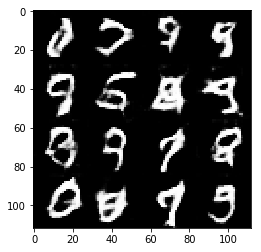

Epoch 2/2... Discriminator Loss: 0.8206... Generator Loss: 1.2959
Epoch 2/2... Discriminator Loss: 1.5847... Generator Loss: 0.4158
Epoch 2/2... Discriminator Loss: 1.3975... Generator Loss: 1.4299
Epoch 2/2... Discriminator Loss: 1.0687... Generator Loss: 1.5223
Epoch 2/2... Discriminator Loss: 1.0156... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 0.9852... Generator Loss: 1.3103
Epoch 2/2... Discriminator Loss: 0.9824... Generator Loss: 1.0193
Epoch 2/2... Discriminator Loss: 0.8553... Generator Loss: 1.4062
Epoch 2/2... Discriminator Loss: 0.8959... Generator Loss: 1.0737
Epoch 2/2... Discriminator Loss: 0.7988... Generator Loss: 1.2235


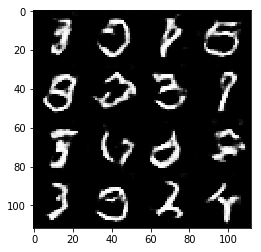

Epoch 2/2... Discriminator Loss: 1.0350... Generator Loss: 1.6495
Epoch 2/2... Discriminator Loss: 1.0205... Generator Loss: 1.1108
Epoch 2/2... Discriminator Loss: 1.2171... Generator Loss: 1.4179
Epoch 2/2... Discriminator Loss: 1.0269... Generator Loss: 1.2138
Epoch 2/2... Discriminator Loss: 0.9971... Generator Loss: 1.1133
Epoch 2/2... Discriminator Loss: 0.8708... Generator Loss: 1.1365
Epoch 2/2... Discriminator Loss: 0.7925... Generator Loss: 1.6591
Epoch 2/2... Discriminator Loss: 0.7365... Generator Loss: 1.4278
Epoch 2/2... Discriminator Loss: 1.1502... Generator Loss: 0.6838
Epoch 2/2... Discriminator Loss: 0.9963... Generator Loss: 0.8074


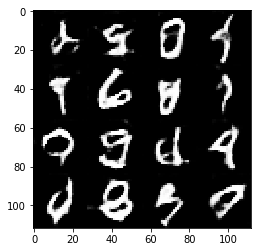

Epoch 2/2... Discriminator Loss: 1.1328... Generator Loss: 0.6752
Epoch 2/2... Discriminator Loss: 1.8078... Generator Loss: 3.2794
Epoch 2/2... Discriminator Loss: 0.8854... Generator Loss: 1.2100
Epoch 2/2... Discriminator Loss: 0.8182... Generator Loss: 1.2516
Epoch 2/2... Discriminator Loss: 0.8226... Generator Loss: 1.2115
Epoch 2/2... Discriminator Loss: 0.9460... Generator Loss: 1.1247
Epoch 2/2... Discriminator Loss: 0.9060... Generator Loss: 1.3375
Epoch 2/2... Discriminator Loss: 0.8723... Generator Loss: 1.9686
Epoch 2/2... Discriminator Loss: 0.9894... Generator Loss: 0.9289
Epoch 2/2... Discriminator Loss: 0.9861... Generator Loss: 0.8571


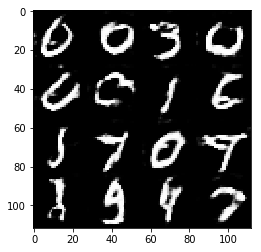

Epoch 2/2... Discriminator Loss: 0.9869... Generator Loss: 1.2532
Epoch 2/2... Discriminator Loss: 1.5685... Generator Loss: 0.4492
Epoch 2/2... Discriminator Loss: 0.9376... Generator Loss: 0.8938
Epoch 2/2... Discriminator Loss: 0.8266... Generator Loss: 1.1679
Epoch 2/2... Discriminator Loss: 0.8919... Generator Loss: 1.4379
Epoch 2/2... Discriminator Loss: 0.7809... Generator Loss: 1.2272
Epoch 2/2... Discriminator Loss: 1.5308... Generator Loss: 0.4774
Epoch 2/2... Discriminator Loss: 1.6651... Generator Loss: 0.4013
Epoch 2/2... Discriminator Loss: 1.0659... Generator Loss: 0.9545
Epoch 2/2... Discriminator Loss: 0.9389... Generator Loss: 1.0629


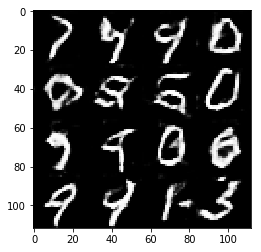

Epoch 2/2... Discriminator Loss: 1.0155... Generator Loss: 1.2232
Epoch 2/2... Discriminator Loss: 0.9148... Generator Loss: 1.6456
Epoch 2/2... Discriminator Loss: 1.0422... Generator Loss: 0.8163
Epoch 2/2... Discriminator Loss: 0.9022... Generator Loss: 1.1793
Epoch 2/2... Discriminator Loss: 0.8668... Generator Loss: 1.2054
Epoch 2/2... Discriminator Loss: 1.0733... Generator Loss: 0.7355
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 1.2731
Epoch 2/2... Discriminator Loss: 0.7776... Generator Loss: 1.3529
Epoch 2/2... Discriminator Loss: 0.9471... Generator Loss: 0.9277
Epoch 2/2... Discriminator Loss: 0.9056... Generator Loss: 1.9237


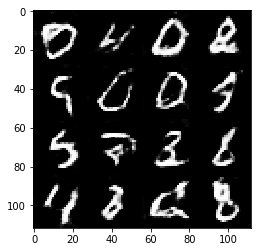

Epoch 2/2... Discriminator Loss: 1.1031... Generator Loss: 0.7656
Epoch 2/2... Discriminator Loss: 0.8260... Generator Loss: 1.6647
Epoch 2/2... Discriminator Loss: 0.8779... Generator Loss: 1.0890
Epoch 2/2... Discriminator Loss: 1.0156... Generator Loss: 0.8764
Epoch 2/2... Discriminator Loss: 0.9968... Generator Loss: 0.8365
Epoch 2/2... Discriminator Loss: 0.8512... Generator Loss: 1.2231
Epoch 2/2... Discriminator Loss: 0.9336... Generator Loss: 0.9678
Epoch 2/2... Discriminator Loss: 0.8436... Generator Loss: 1.5749
Epoch 2/2... Discriminator Loss: 2.2451... Generator Loss: 4.0703
Epoch 2/2... Discriminator Loss: 1.5380... Generator Loss: 2.7303


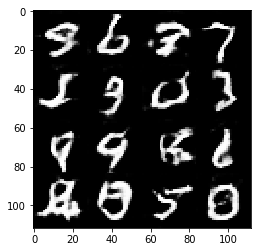

Epoch 2/2... Discriminator Loss: 0.9368... Generator Loss: 0.9813
Epoch 2/2... Discriminator Loss: 1.1862... Generator Loss: 0.6933
Epoch 2/2... Discriminator Loss: 0.9347... Generator Loss: 1.0126
Epoch 2/2... Discriminator Loss: 0.9353... Generator Loss: 1.1667
Epoch 2/2... Discriminator Loss: 0.8985... Generator Loss: 1.4803
Epoch 2/2... Discriminator Loss: 0.9387... Generator Loss: 0.9733
Epoch 2/2... Discriminator Loss: 0.9786... Generator Loss: 0.8436
Epoch 2/2... Discriminator Loss: 0.8791... Generator Loss: 1.6397
Epoch 2/2... Discriminator Loss: 0.7335... Generator Loss: 1.4077
Epoch 2/2... Discriminator Loss: 0.7580... Generator Loss: 1.4652


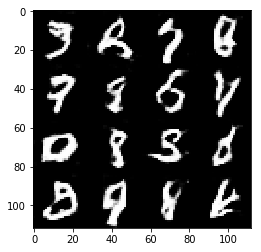

Epoch 2/2... Discriminator Loss: 0.8700... Generator Loss: 1.7933
Epoch 2/2... Discriminator Loss: 1.0495... Generator Loss: 2.2541
Epoch 2/2... Discriminator Loss: 1.3968... Generator Loss: 0.5190
Epoch 2/2... Discriminator Loss: 1.3272... Generator Loss: 2.3733
Epoch 2/2... Discriminator Loss: 0.7931... Generator Loss: 1.1391
Epoch 2/2... Discriminator Loss: 0.8760... Generator Loss: 1.9254
Epoch 2/2... Discriminator Loss: 1.2718... Generator Loss: 2.7068
Epoch 2/2... Discriminator Loss: 1.0078... Generator Loss: 2.2407
Epoch 2/2... Discriminator Loss: 0.8636... Generator Loss: 1.0972
Epoch 2/2... Discriminator Loss: 1.0105... Generator Loss: 0.7893


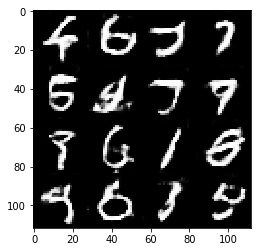

Epoch 2/2... Discriminator Loss: 0.8653... Generator Loss: 1.3952
Epoch 2/2... Discriminator Loss: 0.9914... Generator Loss: 0.8449
Epoch 2/2... Discriminator Loss: 1.1631... Generator Loss: 2.0812
Epoch 2/2... Discriminator Loss: 1.1322... Generator Loss: 0.9057
Epoch 2/2... Discriminator Loss: 1.1925... Generator Loss: 0.6894
Epoch 2/2... Discriminator Loss: 1.0316... Generator Loss: 0.8025
Epoch 2/2... Discriminator Loss: 1.1710... Generator Loss: 0.7384
Epoch 2/2... Discriminator Loss: 1.2715... Generator Loss: 2.0714
Epoch 2/2... Discriminator Loss: 0.9248... Generator Loss: 1.2852
Epoch 2/2... Discriminator Loss: 0.8877... Generator Loss: 1.3549


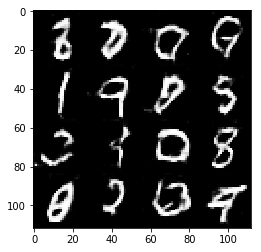

Epoch 2/2... Discriminator Loss: 0.9587... Generator Loss: 0.9502
Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 1.4944
Epoch 2/2... Discriminator Loss: 0.9033... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 0.8460... Generator Loss: 1.2380
Epoch 2/2... Discriminator Loss: 0.7780... Generator Loss: 1.3113
Epoch 2/2... Discriminator Loss: 0.7512... Generator Loss: 1.3741
Epoch 2/2... Discriminator Loss: 0.7319... Generator Loss: 1.5783
Epoch 2/2... Discriminator Loss: 0.9871... Generator Loss: 0.9194
Epoch 2/2... Discriminator Loss: 0.6916... Generator Loss: 1.4142
Epoch 2/2... Discriminator Loss: 0.9086... Generator Loss: 0.9561


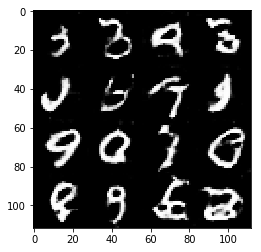

Epoch 2/2... Discriminator Loss: 1.0962... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 0.9306... Generator Loss: 1.7465
Epoch 2/2... Discriminator Loss: 1.0982... Generator Loss: 0.7985
Epoch 2/2... Discriminator Loss: 0.8600... Generator Loss: 1.4893
Epoch 2/2... Discriminator Loss: 0.9417... Generator Loss: 0.9826
Epoch 2/2... Discriminator Loss: 1.3454... Generator Loss: 0.6047
Epoch 2/2... Discriminator Loss: 1.1540... Generator Loss: 0.6739
Epoch 2/2... Discriminator Loss: 0.7658... Generator Loss: 1.2026
Epoch 2/2... Discriminator Loss: 0.7544... Generator Loss: 1.7250
Epoch 2/2... Discriminator Loss: 0.8415... Generator Loss: 1.2836


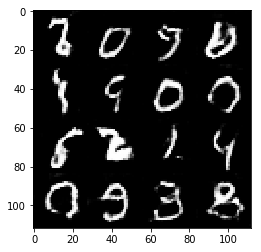

Epoch 2/2... Discriminator Loss: 0.8044... Generator Loss: 1.3061
Epoch 2/2... Discriminator Loss: 0.6888... Generator Loss: 1.9199
Epoch 2/2... Discriminator Loss: 0.8571... Generator Loss: 1.3428
Epoch 2/2... Discriminator Loss: 1.7409... Generator Loss: 3.1353
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 1.3191
Epoch 2/2... Discriminator Loss: 0.8058... Generator Loss: 1.4348
Epoch 2/2... Discriminator Loss: 1.0295... Generator Loss: 0.8138
Epoch 2/2... Discriminator Loss: 0.9130... Generator Loss: 1.0188
Epoch 2/2... Discriminator Loss: 0.7806... Generator Loss: 1.3180
Epoch 2/2... Discriminator Loss: 0.7837... Generator Loss: 1.3411


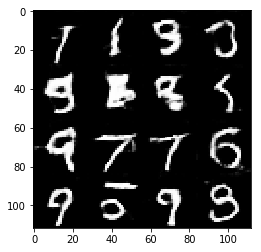

Epoch 2/2... Discriminator Loss: 0.8812... Generator Loss: 1.0498
Epoch 2/2... Discriminator Loss: 0.7074... Generator Loss: 1.5260
Epoch 2/2... Discriminator Loss: 1.3729... Generator Loss: 3.8666
Epoch 2/2... Discriminator Loss: 1.0464... Generator Loss: 0.8013
Epoch 2/2... Discriminator Loss: 0.8595... Generator Loss: 1.1535
Epoch 2/2... Discriminator Loss: 0.7397... Generator Loss: 2.0316
Epoch 2/2... Discriminator Loss: 0.6937... Generator Loss: 1.5415
Epoch 2/2... Discriminator Loss: 0.8258... Generator Loss: 1.9885
Epoch 2/2... Discriminator Loss: 0.9463... Generator Loss: 0.9408
Epoch 2/2... Discriminator Loss: 0.7323... Generator Loss: 1.3035


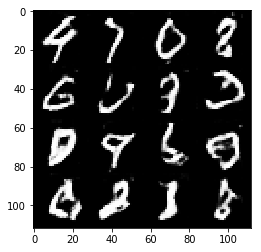

Epoch 2/2... Discriminator Loss: 0.7252... Generator Loss: 1.4109
Epoch 2/2... Discriminator Loss: 0.7693... Generator Loss: 1.3004
Epoch 2/2... Discriminator Loss: 0.8160... Generator Loss: 1.2284
Epoch 2/2... Discriminator Loss: 0.7798... Generator Loss: 1.7215
Epoch 2/2... Discriminator Loss: 0.9227... Generator Loss: 1.2782
Epoch 2/2... Discriminator Loss: 0.7936... Generator Loss: 1.5742
Epoch 2/2... Discriminator Loss: 1.0947... Generator Loss: 0.8005
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 1.3845
Epoch 2/2... Discriminator Loss: 0.9078... Generator Loss: 2.4015
Epoch 2/2... Discriminator Loss: 0.5795... Generator Loss: 2.1963


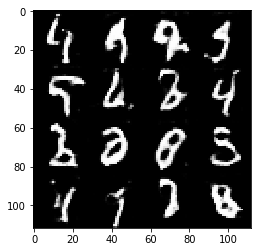

Epoch 2/2... Discriminator Loss: 0.7844... Generator Loss: 1.4751
Epoch 2/2... Discriminator Loss: 0.9241... Generator Loss: 0.9994
Epoch 2/2... Discriminator Loss: 0.9276... Generator Loss: 1.4678
Epoch 2/2... Discriminator Loss: 0.7463... Generator Loss: 1.8192
Epoch 2/2... Discriminator Loss: 2.5009... Generator Loss: 0.2256
Epoch 2/2... Discriminator Loss: 0.9905... Generator Loss: 1.0746
Epoch 2/2... Discriminator Loss: 0.9815... Generator Loss: 1.2621
Epoch 2/2... Discriminator Loss: 0.8314... Generator Loss: 1.2006
Epoch 2/2... Discriminator Loss: 0.7240... Generator Loss: 1.3048
Epoch 2/2... Discriminator Loss: 1.0416... Generator Loss: 0.8384


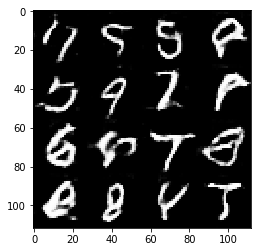

Epoch 2/2... Discriminator Loss: 0.8653... Generator Loss: 1.1447
Epoch 2/2... Discriminator Loss: 0.7696... Generator Loss: 1.7877
Epoch 2/2... Discriminator Loss: 0.7390... Generator Loss: 1.6873
Epoch 2/2... Discriminator Loss: 0.7749... Generator Loss: 1.4742
Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 1.2759
Epoch 2/2... Discriminator Loss: 1.4335... Generator Loss: 0.5645
Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.7912
Epoch 2/2... Discriminator Loss: 1.0326... Generator Loss: 0.8918
Epoch 2/2... Discriminator Loss: 0.8506... Generator Loss: 1.2721
Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 2.6193


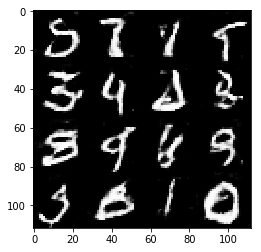

Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 2.0296
Epoch 2/2... Discriminator Loss: 0.9378... Generator Loss: 1.0009
Epoch 2/2... Discriminator Loss: 0.8097... Generator Loss: 2.1381
Epoch 2/2... Discriminator Loss: 0.8219... Generator Loss: 1.4134
Epoch 2/2... Discriminator Loss: 0.7711... Generator Loss: 1.6545
Epoch 2/2... Discriminator Loss: 0.6503... Generator Loss: 1.8412
Epoch 2/2... Discriminator Loss: 0.7664... Generator Loss: 1.3910
Epoch 2/2... Discriminator Loss: 1.1233... Generator Loss: 0.7042
Epoch 2/2... Discriminator Loss: 1.0518... Generator Loss: 0.7608
Epoch 2/2... Discriminator Loss: 0.7193... Generator Loss: 1.6813


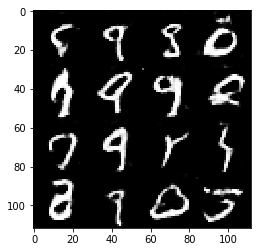

Epoch 2/2... Discriminator Loss: 0.8401... Generator Loss: 1.1774
Epoch 2/2... Discriminator Loss: 0.7593... Generator Loss: 1.3612
Epoch 2/2... Discriminator Loss: 0.7168... Generator Loss: 1.4994
Epoch 2/2... Discriminator Loss: 0.7652... Generator Loss: 1.5769
Epoch 2/2... Discriminator Loss: 0.7411... Generator Loss: 1.3602


In [13]:
batch_size = 32
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.6067
Epoch 1/1... Discriminator Loss: 0.8381... Generator Loss: 1.3945
Epoch 1/1... Discriminator Loss: 0.9631... Generator Loss: 1.1317
Epoch 1/1... Discriminator Loss: 0.9678... Generator Loss: 1.0127
Epoch 1/1... Discriminator Loss: 0.9730... Generator Loss: 4.7462
Epoch 1/1... Discriminator Loss: 0.9262... Generator Loss: 1.2623
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8117
Epoch 1/1... Discriminator Loss: 1.0916... Generator Loss: 0.9308
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.7395
Epoch 1/1... Discriminator Loss: 1.0833... Generator Loss: 1.0453


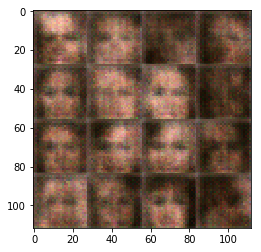

Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 0.9146... Generator Loss: 2.6341
Epoch 1/1... Discriminator Loss: 1.1091... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.6990... Generator Loss: 0.3539
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 1.0127... Generator Loss: 1.2875
Epoch 1/1... Discriminator Loss: 0.9287... Generator Loss: 1.6093
Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.0875... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7115


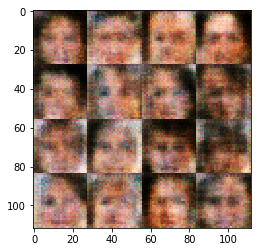

Epoch 1/1... Discriminator Loss: 1.4914... Generator Loss: 0.4854
Epoch 1/1... Discriminator Loss: 1.7081... Generator Loss: 1.8716
Epoch 1/1... Discriminator Loss: 1.7629... Generator Loss: 2.4180
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.5996
Epoch 1/1... Discriminator Loss: 1.7358... Generator Loss: 0.3958
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.4677
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 0.9526... Generator Loss: 1.7115
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 1.2199... Generator Loss: 2.3334


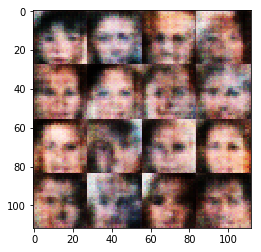

Epoch 1/1... Discriminator Loss: 1.0999... Generator Loss: 0.7981
Epoch 1/1... Discriminator Loss: 1.3920... Generator Loss: 1.5228
Epoch 1/1... Discriminator Loss: 2.0202... Generator Loss: 0.2423
Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.3201
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 1.0308
Epoch 1/1... Discriminator Loss: 1.0998... Generator Loss: 0.9496
Epoch 1/1... Discriminator Loss: 1.2022... Generator Loss: 1.3151


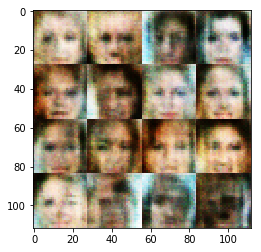

Epoch 1/1... Discriminator Loss: 1.1147... Generator Loss: 1.5831
Epoch 1/1... Discriminator Loss: 1.6690... Generator Loss: 0.3852
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.7254... Generator Loss: 0.5366
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.9862
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.3368
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 2.1763
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 0.9732... Generator Loss: 1.3314


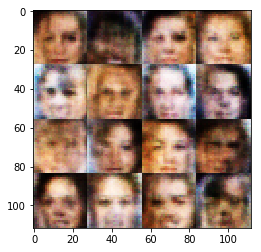

Epoch 1/1... Discriminator Loss: 2.0433... Generator Loss: 0.2358
Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.3954
Epoch 1/1... Discriminator Loss: 1.0615... Generator Loss: 1.3788
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.8618
Epoch 1/1... Discriminator Loss: 1.1698... Generator Loss: 0.7080
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 2.0891
Epoch 1/1... Discriminator Loss: 1.3220... Generator Loss: 1.0856
Epoch 1/1... Discriminator Loss: 1.6434... Generator Loss: 0.6087
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 1.0167


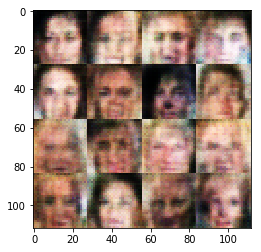

Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.6152
Epoch 1/1... Discriminator Loss: 1.3065... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.0952... Generator Loss: 1.0091
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 1.4529
Epoch 1/1... Discriminator Loss: 1.6388... Generator Loss: 0.3497
Epoch 1/1... Discriminator Loss: 1.5815... Generator Loss: 0.4044
Epoch 1/1... Discriminator Loss: 1.2590... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4951... Generator Loss: 0.6822


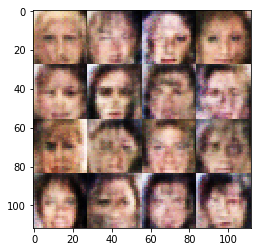

Epoch 1/1... Discriminator Loss: 1.1616... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.1432... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 0.7726
Epoch 1/1... Discriminator Loss: 1.4375... Generator Loss: 0.5703
Epoch 1/1... Discriminator Loss: 1.1615... Generator Loss: 1.0100
Epoch 1/1... Discriminator Loss: 1.9352... Generator Loss: 0.9050
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.6070
Epoch 1/1... Discriminator Loss: 1.7912... Generator Loss: 0.3218
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.6417


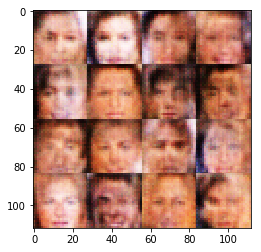

Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.5310
Epoch 1/1... Discriminator Loss: 1.3539... Generator Loss: 1.1780
Epoch 1/1... Discriminator Loss: 1.5355... Generator Loss: 0.5872
Epoch 1/1... Discriminator Loss: 1.6623... Generator Loss: 0.4841
Epoch 1/1... Discriminator Loss: 1.9473... Generator Loss: 0.3836
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.8080
Epoch 1/1... Discriminator Loss: 1.2419... Generator Loss: 1.1810
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.6049... Generator Loss: 0.4253
Epoch 1/1... Discriminator Loss: 1.7472... Generator Loss: 0.6670


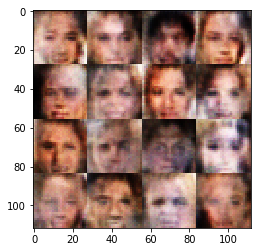

Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 1.6097... Generator Loss: 0.5133
Epoch 1/1... Discriminator Loss: 1.6121... Generator Loss: 0.4232
Epoch 1/1... Discriminator Loss: 1.5862... Generator Loss: 0.4746
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.8252
Epoch 1/1... Discriminator Loss: 1.4577... Generator Loss: 0.6520
Epoch 1/1... Discriminator Loss: 1.7943... Generator Loss: 0.5855
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.8044
Epoch 1/1... Discriminator Loss: 1.2674... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.5881


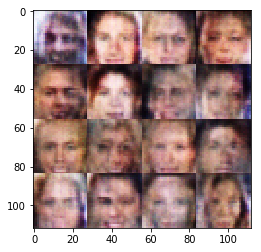

Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.6970
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.0310... Generator Loss: 1.0987
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3637... Generator Loss: 0.6777
Epoch 1/1... Discriminator Loss: 1.4509... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.9157
Epoch 1/1... Discriminator Loss: 1.8479... Generator Loss: 0.4148
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.8777
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6110


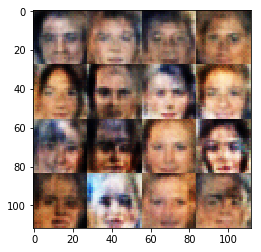

Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.5697... Generator Loss: 0.6555
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.4471... Generator Loss: 0.9870
Epoch 1/1... Discriminator Loss: 1.3576... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.2047... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.8030
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6996


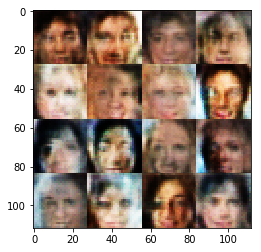

Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7903
Epoch 1/1... Discriminator Loss: 1.3524... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.6758
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3756... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.6469... Generator Loss: 0.5019
Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.7730


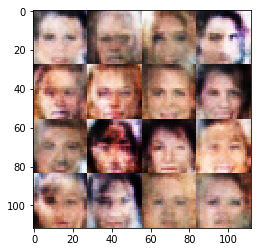

Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.4517... Generator Loss: 0.6111
Epoch 1/1... Discriminator Loss: 1.5058... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.6589
Epoch 1/1... Discriminator Loss: 1.3554... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.5727
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.5764
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 1.0145
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.9163


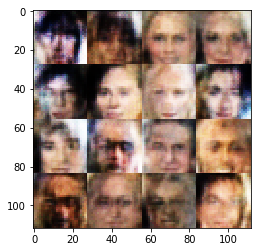

Epoch 1/1... Discriminator Loss: 1.3590... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.1585... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.2486... Generator Loss: 0.8967
Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.5954... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.2413... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.3206... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.4272... Generator Loss: 0.6178


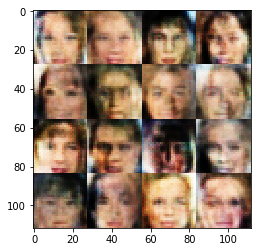

Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8333
Epoch 1/1... Discriminator Loss: 1.4315... Generator Loss: 0.5657
Epoch 1/1... Discriminator Loss: 1.3510... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.3820... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.8722
Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.9640
Epoch 1/1... Discriminator Loss: 1.2727... Generator Loss: 0.7025


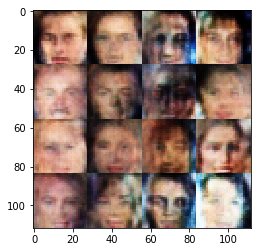

Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.9822
Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.3557... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.3345... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 1.1158
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.2575... Generator Loss: 0.8510
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.7953


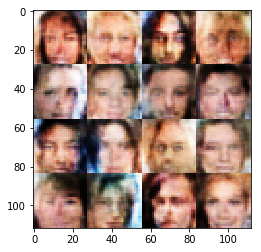

Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.5314
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.9141
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.6738
Epoch 1/1... Discriminator Loss: 1.3830... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.7349
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.8390
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.5559... Generator Loss: 0.6214


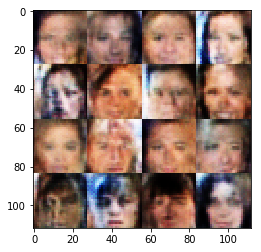

Epoch 1/1... Discriminator Loss: 1.2320... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.9067
Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 1.0207
Epoch 1/1... Discriminator Loss: 1.2653... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.0283
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.7500
Epoch 1/1... Discriminator Loss: 1.2471... Generator Loss: 0.9955
Epoch 1/1... Discriminator Loss: 1.3256... Generator Loss: 0.9556
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.7858


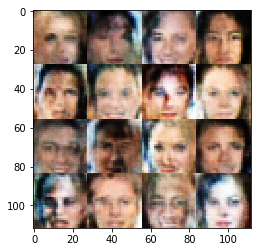

Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7230
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.9658
Epoch 1/1... Discriminator Loss: 1.3085... Generator Loss: 0.8765
Epoch 1/1... Discriminator Loss: 1.2132... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.6807
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.9843
Epoch 1/1... Discriminator Loss: 1.2041... Generator Loss: 0.9445
Epoch 1/1... Discriminator Loss: 1.2455... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 1.1983... Generator Loss: 0.9921
Epoch 1/1... Discriminator Loss: 1.2550... Generator Loss: 0.9295


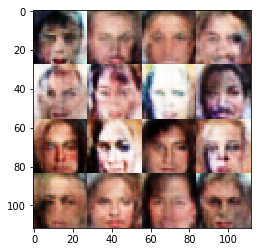

Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.8284
Epoch 1/1... Discriminator Loss: 1.2197... Generator Loss: 0.9573
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.9837
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.8202
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.8223
Epoch 1/1... Discriminator Loss: 1.3219... Generator Loss: 0.9800
Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 1.4875... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.7802


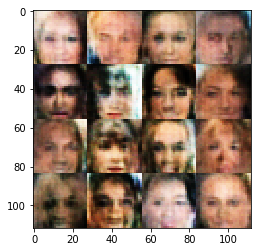

Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.3044... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6130
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.9017
Epoch 1/1... Discriminator Loss: 1.4455... Generator Loss: 0.5927
Epoch 1/1... Discriminator Loss: 1.2893... Generator Loss: 0.7622
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.6549
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.6929
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.8072


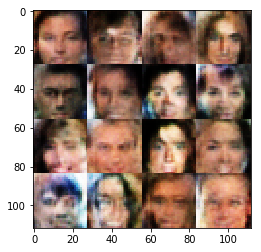

Epoch 1/1... Discriminator Loss: 1.2100... Generator Loss: 0.9705
Epoch 1/1... Discriminator Loss: 1.3665... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.4987
Epoch 1/1... Discriminator Loss: 1.2173... Generator Loss: 0.8495
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.9508
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.6199
Epoch 1/1... Discriminator Loss: 1.4117... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.6845
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.9173


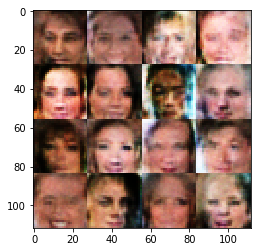

Epoch 1/1... Discriminator Loss: 1.0402... Generator Loss: 1.1630
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4400... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 1.3697
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.5810... Generator Loss: 0.5405
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 1.3965
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.8731
Epoch 1/1... Discriminator Loss: 1.1922... Generator Loss: 0.7484


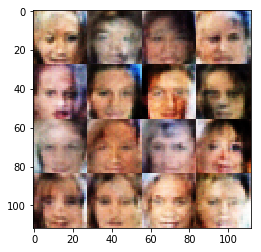

Epoch 1/1... Discriminator Loss: 1.2843... Generator Loss: 0.6693
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 1.1062
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.8782
Epoch 1/1... Discriminator Loss: 1.5592... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.8727
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.3126... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.1670... Generator Loss: 0.8165


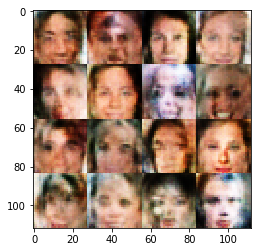

Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 0.8666
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 1.1337
Epoch 1/1... Discriminator Loss: 1.2638... Generator Loss: 0.7056
Epoch 1/1... Discriminator Loss: 1.3620... Generator Loss: 0.6378
Epoch 1/1... Discriminator Loss: 1.3856... Generator Loss: 0.9144
Epoch 1/1... Discriminator Loss: 1.3401... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.8303
Epoch 1/1... Discriminator Loss: 1.2056... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 1.2430... Generator Loss: 0.9064


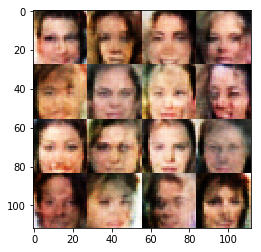

Epoch 1/1... Discriminator Loss: 1.3423... Generator Loss: 0.8441
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.7380
Epoch 1/1... Discriminator Loss: 1.2645... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.9476
Epoch 1/1... Discriminator Loss: 1.0372... Generator Loss: 1.1024
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.3370... Generator Loss: 1.0255
Epoch 1/1... Discriminator Loss: 1.1754... Generator Loss: 1.1776
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7190


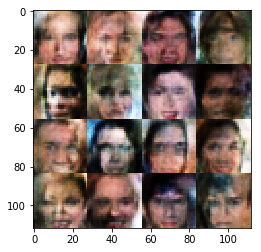

Epoch 1/1... Discriminator Loss: 1.2177... Generator Loss: 0.8165
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.8473
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.6064
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.9488
Epoch 1/1... Discriminator Loss: 1.3096... Generator Loss: 1.0482
Epoch 1/1... Discriminator Loss: 1.3693... Generator Loss: 0.8823
Epoch 1/1... Discriminator Loss: 1.2778... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.9893


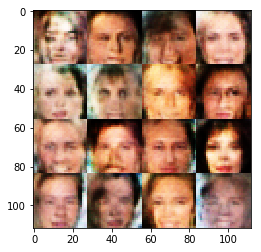

Epoch 1/1... Discriminator Loss: 1.3730... Generator Loss: 0.8400
Epoch 1/1... Discriminator Loss: 1.4086... Generator Loss: 0.8107
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.5566
Epoch 1/1... Discriminator Loss: 1.3350... Generator Loss: 0.8545
Epoch 1/1... Discriminator Loss: 1.4197... Generator Loss: 0.6578
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 1.1386
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.9406
Epoch 1/1... Discriminator Loss: 1.1887... Generator Loss: 0.9291
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 1.0388


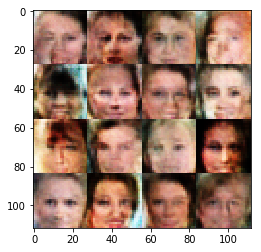

Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.8990
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.3574... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.4678... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 1.1088... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.6194
Epoch 1/1... Discriminator Loss: 1.0881... Generator Loss: 1.2325
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.6622
Epoch 1/1... Discriminator Loss: 1.3430... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.1770... Generator Loss: 0.9040


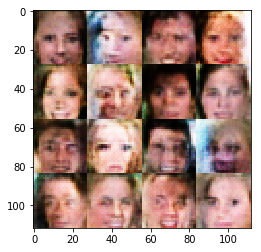

Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.9596
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.9380
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.9763
Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.5775
Epoch 1/1... Discriminator Loss: 1.1139... Generator Loss: 1.0004
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.5839
Epoch 1/1... Discriminator Loss: 1.1553... Generator Loss: 0.8231


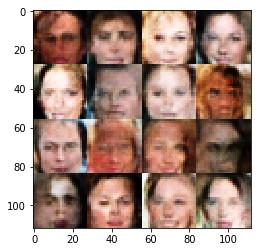

Epoch 1/1... Discriminator Loss: 1.2381... Generator Loss: 0.9247
Epoch 1/1... Discriminator Loss: 1.4125... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.4260... Generator Loss: 0.4994
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7822
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.6756
Epoch 1/1... Discriminator Loss: 1.2359... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.2384... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.8071
Epoch 1/1... Discriminator Loss: 1.1919... Generator Loss: 1.1454


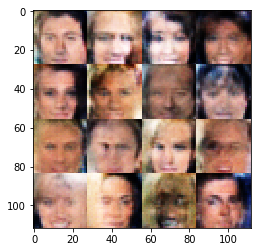

Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.7121
Epoch 1/1... Discriminator Loss: 1.1246... Generator Loss: 0.9135
Epoch 1/1... Discriminator Loss: 1.6688... Generator Loss: 0.3822
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.8939
Epoch 1/1... Discriminator Loss: 1.1260... Generator Loss: 1.0905
Epoch 1/1... Discriminator Loss: 1.1633... Generator Loss: 1.2226
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.2243... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.9150
Epoch 1/1... Discriminator Loss: 1.0014... Generator Loss: 1.1722


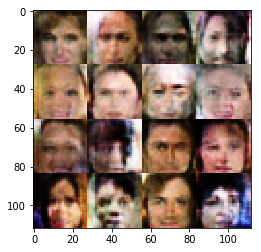

Epoch 1/1... Discriminator Loss: 1.4568... Generator Loss: 0.5045
Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7311
Epoch 1/1... Discriminator Loss: 1.2226... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.9251
Epoch 1/1... Discriminator Loss: 1.5818... Generator Loss: 0.5520
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 1.5292... Generator Loss: 0.5482
Epoch 1/1... Discriminator Loss: 1.0407... Generator Loss: 1.0607


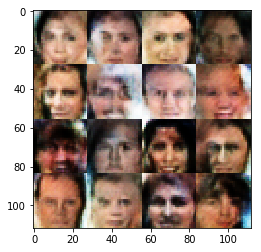

Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 1.3046... Generator Loss: 0.6954
Epoch 1/1... Discriminator Loss: 1.4136... Generator Loss: 0.4759
Epoch 1/1... Discriminator Loss: 1.3677... Generator Loss: 0.7204
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 0.8529... Generator Loss: 1.4578
Epoch 1/1... Discriminator Loss: 1.1787... Generator Loss: 0.6807


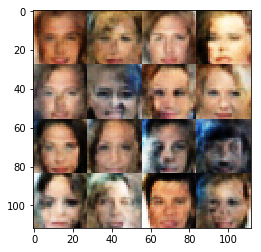

Epoch 1/1... Discriminator Loss: 1.3034... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.1212... Generator Loss: 1.0968
Epoch 1/1... Discriminator Loss: 1.4465... Generator Loss: 1.6323
Epoch 1/1... Discriminator Loss: 1.2754... Generator Loss: 1.1483
Epoch 1/1... Discriminator Loss: 1.2572... Generator Loss: 0.6902
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.8987
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.7495
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.7539... Generator Loss: 0.3991


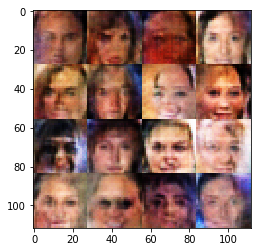

Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.9803
Epoch 1/1... Discriminator Loss: 1.0352... Generator Loss: 0.9670
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.0593... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.6082
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.8849
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.9490
Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 1.5012
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.0351... Generator Loss: 1.0204


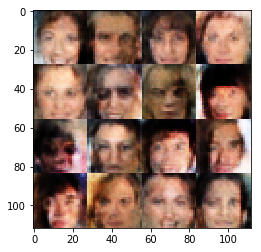

Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.7497
Epoch 1/1... Discriminator Loss: 1.3606... Generator Loss: 0.9899
Epoch 1/1... Discriminator Loss: 1.5014... Generator Loss: 0.5419
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.3528
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.1203... Generator Loss: 0.9267
Epoch 1/1... Discriminator Loss: 1.3561... Generator Loss: 0.8586
Epoch 1/1... Discriminator Loss: 1.2180... Generator Loss: 0.7724


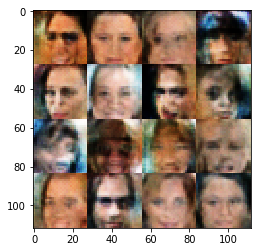

Epoch 1/1... Discriminator Loss: 1.4903... Generator Loss: 0.8329
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.4931... Generator Loss: 0.5050
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.6923
Epoch 1/1... Discriminator Loss: 1.3877... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.6037
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.5089


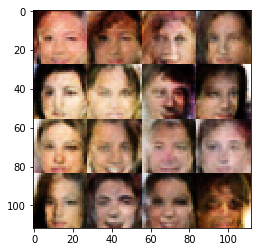

Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.8972
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.8741
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.6631
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.7528
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.0686... Generator Loss: 1.0202
Epoch 1/1... Discriminator Loss: 1.2549... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.3941... Generator Loss: 0.7325


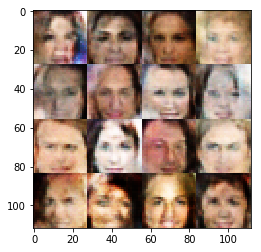

Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.9451
Epoch 1/1... Discriminator Loss: 1.1015... Generator Loss: 1.3553
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6892
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.6947
Epoch 1/1... Discriminator Loss: 1.2027... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.4813... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.2599... Generator Loss: 0.8228
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 1.1484
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 0.9901


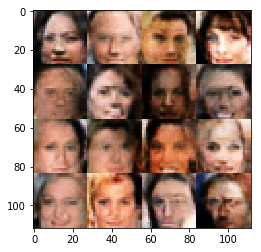

Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.5070... Generator Loss: 0.5622
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.9240
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.6046
Epoch 1/1... Discriminator Loss: 1.1535... Generator Loss: 0.9309
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.6225... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.3441... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7961
Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.8935


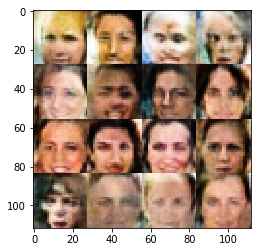

Epoch 1/1... Discriminator Loss: 1.2806... Generator Loss: 0.7447
Epoch 1/1... Discriminator Loss: 1.3355... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.4881... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.4698... Generator Loss: 0.8328
Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.6485
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.6381
Epoch 1/1... Discriminator Loss: 1.3466... Generator Loss: 0.5487
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 1.1129
Epoch 1/1... Discriminator Loss: 1.6365... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.0080... Generator Loss: 1.1198


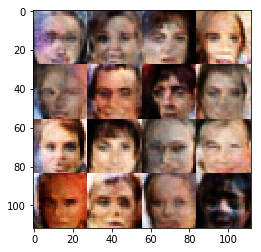

Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 0.8011
Epoch 1/1... Discriminator Loss: 1.1625... Generator Loss: 0.9323
Epoch 1/1... Discriminator Loss: 1.4683... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.3624... Generator Loss: 0.6177
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.3456... Generator Loss: 0.7092
Epoch 1/1... Discriminator Loss: 1.2532... Generator Loss: 0.8713
Epoch 1/1... Discriminator Loss: 1.3354... Generator Loss: 0.7228
Epoch 1/1... Discriminator Loss: 1.4528... Generator Loss: 0.5872


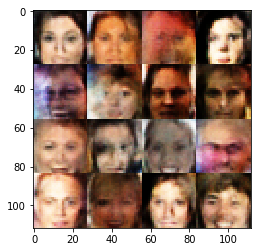

Epoch 1/1... Discriminator Loss: 1.2330... Generator Loss: 0.9629
Epoch 1/1... Discriminator Loss: 1.3702... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 1.3242... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.5148
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.8274
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.1884... Generator Loss: 0.8430
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.9541
Epoch 1/1... Discriminator Loss: 1.3617... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.3379... Generator Loss: 0.7331


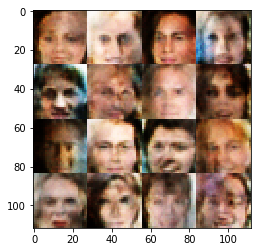

Epoch 1/1... Discriminator Loss: 1.1823... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.6668
Epoch 1/1... Discriminator Loss: 1.3540... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.2499... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 0.9313... Generator Loss: 1.3001
Epoch 1/1... Discriminator Loss: 1.1544... Generator Loss: 1.1054
Epoch 1/1... Discriminator Loss: 1.2723... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.5442
Epoch 1/1... Discriminator Loss: 1.4815... Generator Loss: 0.8873


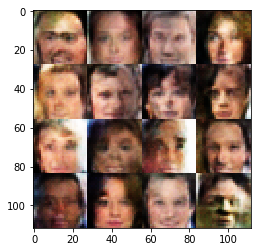

Epoch 1/1... Discriminator Loss: 1.0896... Generator Loss: 1.0567
Epoch 1/1... Discriminator Loss: 1.2208... Generator Loss: 0.8691
Epoch 1/1... Discriminator Loss: 1.0457... Generator Loss: 1.0503
Epoch 1/1... Discriminator Loss: 1.1564... Generator Loss: 0.8976
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.6376
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.6774
Epoch 1/1... Discriminator Loss: 1.1256... Generator Loss: 1.0146
Epoch 1/1... Discriminator Loss: 1.5782... Generator Loss: 0.5519
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.9458


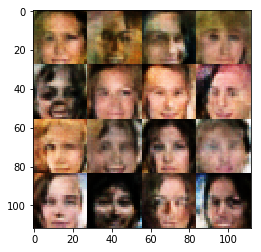

Epoch 1/1... Discriminator Loss: 1.2979... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.2452... Generator Loss: 0.9275
Epoch 1/1... Discriminator Loss: 1.5186... Generator Loss: 0.6286
Epoch 1/1... Discriminator Loss: 1.4934... Generator Loss: 0.5236
Epoch 1/1... Discriminator Loss: 1.4575... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.2078... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.1726... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.5057... Generator Loss: 0.5570
Epoch 1/1... Discriminator Loss: 1.5065... Generator Loss: 0.5485


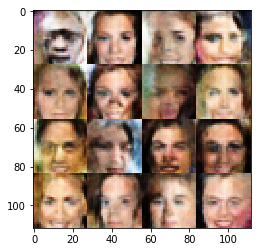

Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.7132
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.2703... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.1467... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.2717... Generator Loss: 0.8140
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9200
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.7530


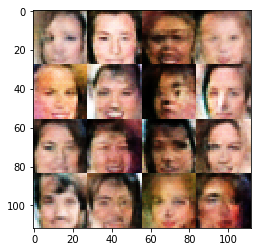

Epoch 1/1... Discriminator Loss: 1.4837... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.1172... Generator Loss: 1.0967
Epoch 1/1... Discriminator Loss: 1.2143... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.2046... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 1.2901... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.7676


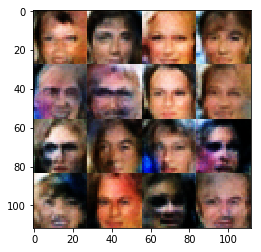

Epoch 1/1... Discriminator Loss: 1.2443... Generator Loss: 0.7379
Epoch 1/1... Discriminator Loss: 1.1427... Generator Loss: 0.9978
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.6380
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.8557
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.5453... Generator Loss: 0.4720
Epoch 1/1... Discriminator Loss: 1.2875... Generator Loss: 0.9403
Epoch 1/1... Discriminator Loss: 1.4185... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.7354


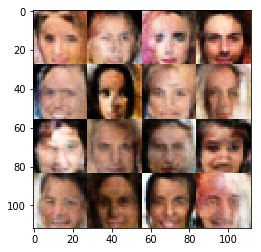

Epoch 1/1... Discriminator Loss: 1.1394... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.8074
Epoch 1/1... Discriminator Loss: 1.6276... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.8961
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.4765... Generator Loss: 1.0442
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 0.6638
Epoch 1/1... Discriminator Loss: 1.1443... Generator Loss: 0.8979
Epoch 1/1... Discriminator Loss: 1.5034... Generator Loss: 0.7865


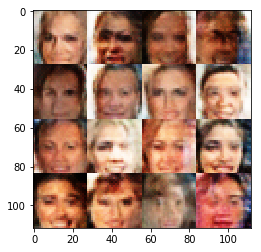

Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.4691
Epoch 1/1... Discriminator Loss: 1.1188... Generator Loss: 1.1037
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 1.0043
Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.4394
Epoch 1/1... Discriminator Loss: 1.3064... Generator Loss: 0.6576
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.7150
Epoch 1/1... Discriminator Loss: 1.2133... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.5158... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 1.0043... Generator Loss: 1.0793


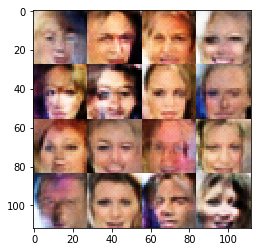

Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.2493... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.3374... Generator Loss: 0.7992
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.9328
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.2524... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.1451... Generator Loss: 1.2194
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.5505
Epoch 1/1... Discriminator Loss: 1.3596... Generator Loss: 0.6985


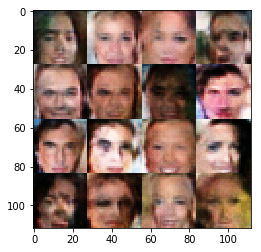

Epoch 1/1... Discriminator Loss: 1.4724... Generator Loss: 0.5808
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.8062
Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.5691
Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 1.0451
Epoch 1/1... Discriminator Loss: 1.0990... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.1545... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.5257


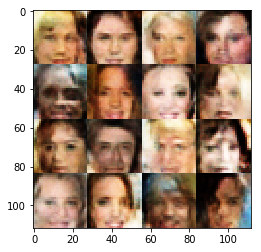

Epoch 1/1... Discriminator Loss: 1.3508... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.2258... Generator Loss: 0.7538
Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.0950
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.6718... Generator Loss: 0.4290
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.5801
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.6595
Epoch 1/1... Discriminator Loss: 1.3110... Generator Loss: 0.9964
Epoch 1/1... Discriminator Loss: 1.2528... Generator Loss: 0.8690
Epoch 1/1... Discriminator Loss: 1.2340... Generator Loss: 0.9441


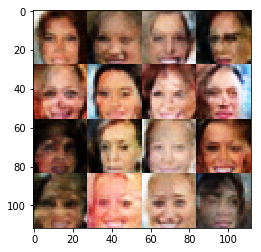

Epoch 1/1... Discriminator Loss: 1.2675... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.1691... Generator Loss: 0.9199
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 0.7984
Epoch 1/1... Discriminator Loss: 1.4313... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.2073... Generator Loss: 0.7166
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.9350
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.8412
Epoch 1/1... Discriminator Loss: 1.2336... Generator Loss: 0.8209


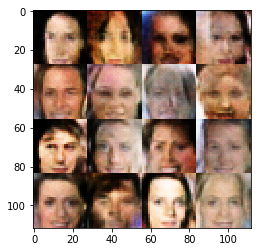

Epoch 1/1... Discriminator Loss: 1.3482... Generator Loss: 0.6713
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.8182
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 1.2250... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.2124... Generator Loss: 0.9179
Epoch 1/1... Discriminator Loss: 1.2023... Generator Loss: 0.9272
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 1.2326
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6740


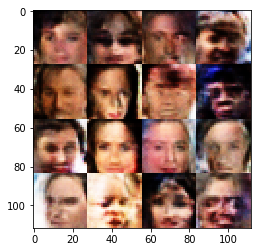

Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.6822
Epoch 1/1... Discriminator Loss: 1.2033... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.8179
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.6159
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 1.1197
Epoch 1/1... Discriminator Loss: 1.2977... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.2356... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.8290
Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 1.1059


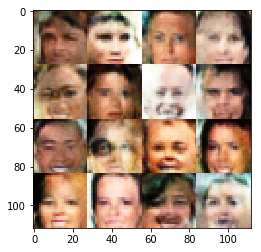

Epoch 1/1... Discriminator Loss: 1.2089... Generator Loss: 0.8266
Epoch 1/1... Discriminator Loss: 1.2195... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.3422... Generator Loss: 0.7820
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.1802... Generator Loss: 0.9991
Epoch 1/1... Discriminator Loss: 1.1617... Generator Loss: 1.0705
Epoch 1/1... Discriminator Loss: 1.3238... Generator Loss: 1.0983
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8919


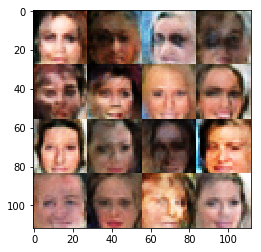

Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.2497... Generator Loss: 0.8738
Epoch 1/1... Discriminator Loss: 1.4219... Generator Loss: 0.7079
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 0.9672
Epoch 1/1... Discriminator Loss: 1.3686... Generator Loss: 0.9040
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6148
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.4261... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.9655
Epoch 1/1... Discriminator Loss: 1.2280... Generator Loss: 0.7088


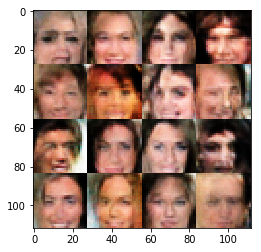

Epoch 1/1... Discriminator Loss: 1.0962... Generator Loss: 1.0447
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.1132... Generator Loss: 0.8775
Epoch 1/1... Discriminator Loss: 1.5843... Generator Loss: 0.3985
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 1.2265
Epoch 1/1... Discriminator Loss: 1.3447... Generator Loss: 1.0792
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.7775
Epoch 1/1... Discriminator Loss: 1.2685... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.2968... Generator Loss: 0.7508


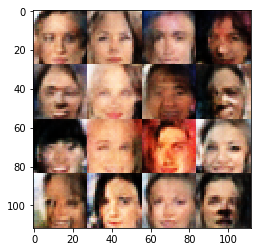

Epoch 1/1... Discriminator Loss: 1.3404... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6270
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.4100... Generator Loss: 0.5578
Epoch 1/1... Discriminator Loss: 1.2672... Generator Loss: 0.8818
Epoch 1/1... Discriminator Loss: 1.3409... Generator Loss: 0.7839
Epoch 1/1... Discriminator Loss: 0.9330... Generator Loss: 1.2787
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.2211... Generator Loss: 0.8965
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6781


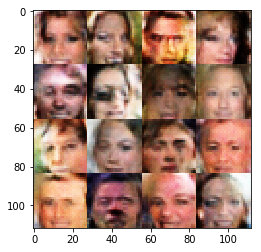

Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.6014
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 1.2495
Epoch 1/1... Discriminator Loss: 1.4556... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.2660... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.7650
Epoch 1/1... Discriminator Loss: 1.3672... Generator Loss: 0.6836
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.0505
Epoch 1/1... Discriminator Loss: 1.3450... Generator Loss: 0.5096
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.3090... Generator Loss: 0.6462


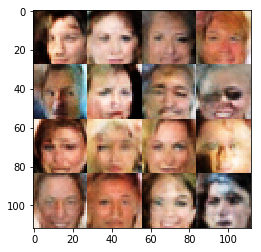

Epoch 1/1... Discriminator Loss: 1.2397... Generator Loss: 0.8128
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.8784
Epoch 1/1... Discriminator Loss: 1.2357... Generator Loss: 0.9474
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.7274
Epoch 1/1... Discriminator Loss: 1.5694... Generator Loss: 0.4402
Epoch 1/1... Discriminator Loss: 1.1804... Generator Loss: 0.9936
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.1527... Generator Loss: 0.9119
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.8366
Epoch 1/1... Discriminator Loss: 1.1581... Generator Loss: 0.9002


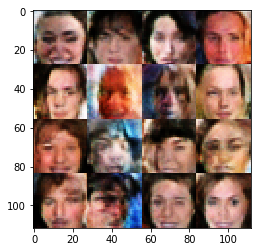

Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.6944
Epoch 1/1... Discriminator Loss: 1.1314... Generator Loss: 1.2522
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7563
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.8312
Epoch 1/1... Discriminator Loss: 1.4458... Generator Loss: 0.5424
Epoch 1/1... Discriminator Loss: 1.0761... Generator Loss: 1.0257
Epoch 1/1... Discriminator Loss: 1.4443... Generator Loss: 0.8010
Epoch 1/1... Discriminator Loss: 1.1932... Generator Loss: 0.8559
Epoch 1/1... Discriminator Loss: 1.3102... Generator Loss: 0.7598
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.8257


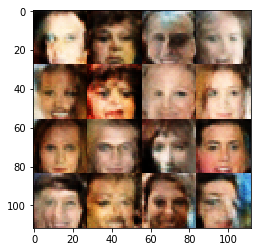

Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.8132
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.5994
Epoch 1/1... Discriminator Loss: 1.1916... Generator Loss: 0.9542
Epoch 1/1... Discriminator Loss: 1.0862... Generator Loss: 1.0236
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7177
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 1.2189
Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.4329
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.1813... Generator Loss: 0.8267


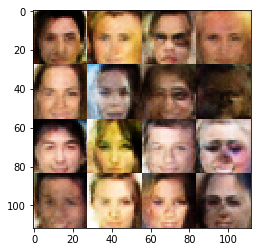

Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 1.2361
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.4690... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.6234
Epoch 1/1... Discriminator Loss: 1.2639... Generator Loss: 0.6630
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.0958
Epoch 1/1... Discriminator Loss: 1.1958... Generator Loss: 0.8805


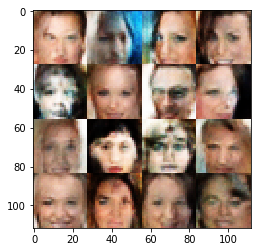

Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.8724
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.9037
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.3943... Generator Loss: 0.5883
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.5650
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.8082
Epoch 1/1... Discriminator Loss: 1.3055... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.8113


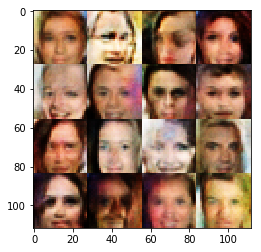

Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.8092
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.4028... Generator Loss: 0.5260
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.2984... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.2719... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.1101... Generator Loss: 0.9752
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.7010


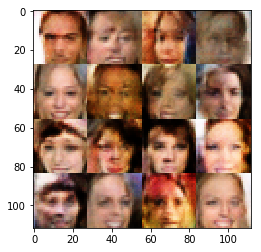

Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.7186
Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8525
Epoch 1/1... Discriminator Loss: 1.4770... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.2411... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.5517... Generator Loss: 0.8839
Epoch 1/1... Discriminator Loss: 1.0271... Generator Loss: 1.0485
Epoch 1/1... Discriminator Loss: 1.4479... Generator Loss: 0.5683


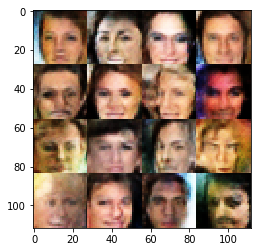

Epoch 1/1... Discriminator Loss: 1.1436... Generator Loss: 0.9358
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.3083... Generator Loss: 0.8172
Epoch 1/1... Discriminator Loss: 1.4189... Generator Loss: 0.7183
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.4922
Epoch 1/1... Discriminator Loss: 1.4970... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.2084... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.1900... Generator Loss: 0.7936
Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.8926


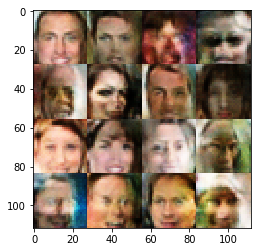

Epoch 1/1... Discriminator Loss: 1.6375... Generator Loss: 0.4909
Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9954
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.9457
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.8602
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.0796... Generator Loss: 1.1881
Epoch 1/1... Discriminator Loss: 1.3321... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.1609... Generator Loss: 0.8263
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.3100


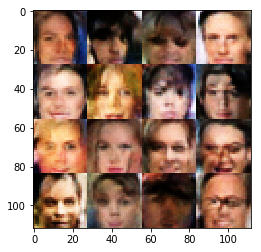

Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.6950
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.7944
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.6715
Epoch 1/1... Discriminator Loss: 1.3368... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.8028
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.7526


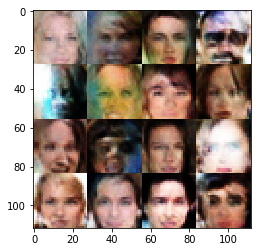

Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.5758
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.8314
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 1.0045
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 0.8718
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.9711
Epoch 1/1... Discriminator Loss: 1.2556... Generator Loss: 0.8433
Epoch 1/1... Discriminator Loss: 1.4711... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.6591


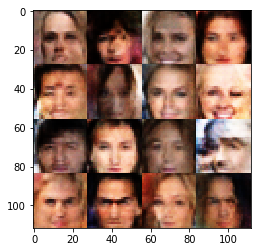

Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.8983
Epoch 1/1... Discriminator Loss: 1.5527... Generator Loss: 0.4491
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8370
Epoch 1/1... Discriminator Loss: 1.0873... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 1.2958... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.6000
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.1241... Generator Loss: 0.9506
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.3715... Generator Loss: 0.7494


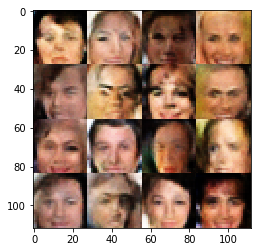

Epoch 1/1... Discriminator Loss: 1.4778... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4715... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.1554... Generator Loss: 1.0384
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.7460
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.5394
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.5299... Generator Loss: 0.5244
Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.8239


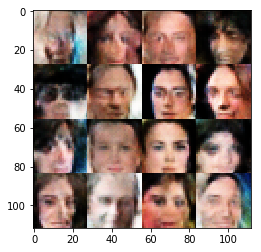

Epoch 1/1... Discriminator Loss: 1.0891... Generator Loss: 0.9663
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.2385... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.6795
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.6552
Epoch 1/1... Discriminator Loss: 1.2044... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.1800... Generator Loss: 0.8856
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.2491... Generator Loss: 0.6882
Epoch 1/1... Discriminator Loss: 1.3764... Generator Loss: 0.6519


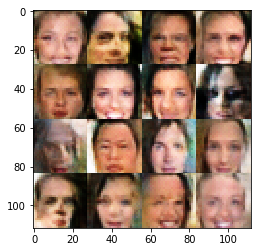

Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.6876
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.9311
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.6558
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.7137
Epoch 1/1... Discriminator Loss: 1.2859... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.5485
Epoch 1/1... Discriminator Loss: 1.4506... Generator Loss: 0.6040
Epoch 1/1... Discriminator Loss: 1.2595... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.2369... Generator Loss: 0.8071


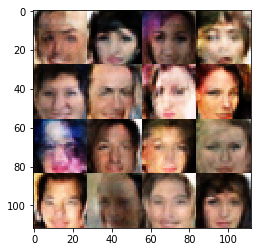

Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.6886
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 1.2179
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.8726
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7368
Epoch 1/1... Discriminator Loss: 1.4114... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.2127... Generator Loss: 0.7346
Epoch 1/1... Discriminator Loss: 1.1674... Generator Loss: 0.8507


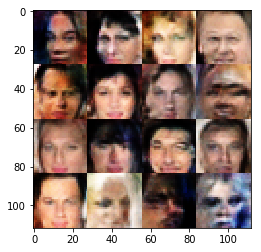

Epoch 1/1... Discriminator Loss: 1.1870... Generator Loss: 0.9342
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.4476... Generator Loss: 0.5716
Epoch 1/1... Discriminator Loss: 1.3623... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.2111... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.3707... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 1.1281... Generator Loss: 1.0725
Epoch 1/1... Discriminator Loss: 1.2159... Generator Loss: 0.9777
Epoch 1/1... Discriminator Loss: 1.2297... Generator Loss: 0.8201


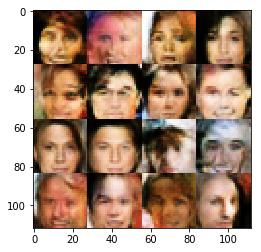

Epoch 1/1... Discriminator Loss: 1.3786... Generator Loss: 0.9773
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7405
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 1.1314
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 0.6962
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.3696... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.4980... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.3618... Generator Loss: 0.6678
Epoch 1/1... Discriminator Loss: 1.3390... Generator Loss: 0.6623


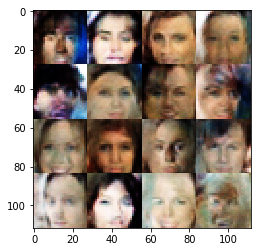

Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.9817
Epoch 1/1... Discriminator Loss: 1.3176... Generator Loss: 0.6812
Epoch 1/1... Discriminator Loss: 1.0298... Generator Loss: 1.4958
Epoch 1/1... Discriminator Loss: 1.4193... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.1450... Generator Loss: 1.0623
Epoch 1/1... Discriminator Loss: 1.3414... Generator Loss: 1.0316
Epoch 1/1... Discriminator Loss: 1.4003... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.2447... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.2139... Generator Loss: 1.0473
Epoch 1/1... Discriminator Loss: 1.3371... Generator Loss: 1.0130


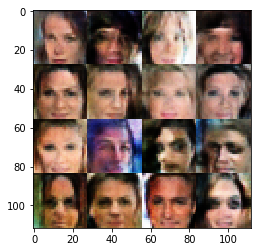

Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.9276
Epoch 1/1... Discriminator Loss: 0.9243... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 1.2472... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.8058
Epoch 1/1... Discriminator Loss: 1.3315... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 0.9368
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.9197
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.6145
Epoch 1/1... Discriminator Loss: 1.4885... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 1.0304


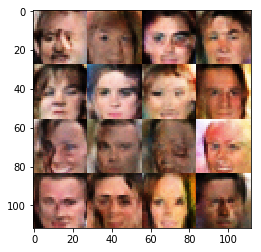

Epoch 1/1... Discriminator Loss: 1.5182... Generator Loss: 0.4902
Epoch 1/1... Discriminator Loss: 1.2691... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.2721... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.2154... Generator Loss: 0.8114
Epoch 1/1... Discriminator Loss: 1.6427... Generator Loss: 0.4418
Epoch 1/1... Discriminator Loss: 1.1325... Generator Loss: 1.3286
Epoch 1/1... Discriminator Loss: 1.2020... Generator Loss: 0.9421
Epoch 1/1... Discriminator Loss: 1.4549... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.1749... Generator Loss: 1.1943


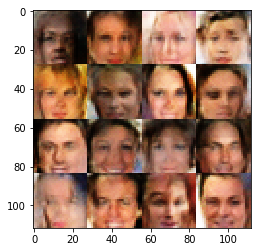

Epoch 1/1... Discriminator Loss: 1.0734... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 1.3229... Generator Loss: 0.7559
Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.8283
Epoch 1/1... Discriminator Loss: 1.1806... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.5326... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 1.3272... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.5561
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.0376
Epoch 1/1... Discriminator Loss: 1.0424... Generator Loss: 1.1212
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7982


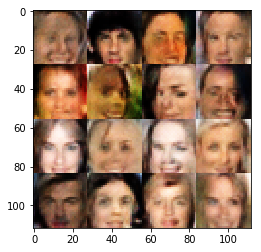

Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 1.0294
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 1.2170... Generator Loss: 0.8968
Epoch 1/1... Discriminator Loss: 1.2334... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.3669... Generator Loss: 0.5939
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.6584


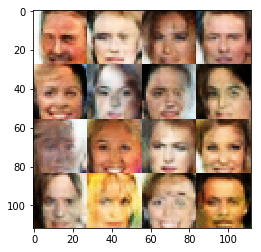

Epoch 1/1... Discriminator Loss: 1.4360... Generator Loss: 0.6489
Epoch 1/1... Discriminator Loss: 1.1600... Generator Loss: 0.9703
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.9678
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.6313
Epoch 1/1... Discriminator Loss: 1.2512... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.3365... Generator Loss: 0.6770
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.6535
Epoch 1/1... Discriminator Loss: 1.3131... Generator Loss: 0.7797
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.8095
Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.7821


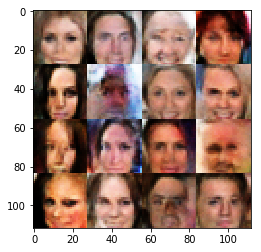

Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.7265
Epoch 1/1... Discriminator Loss: 1.2026... Generator Loss: 0.9261
Epoch 1/1... Discriminator Loss: 1.3179... Generator Loss: 0.6369
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 1.0158
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.8310
Epoch 1/1... Discriminator Loss: 1.4437... Generator Loss: 0.6282
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.8464
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.7804
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.8443
Epoch 1/1... Discriminator Loss: 1.4386... Generator Loss: 0.5819


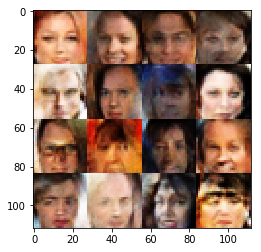

Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 1.0319
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.9008
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.9621
Epoch 1/1... Discriminator Loss: 1.1700... Generator Loss: 0.9515
Epoch 1/1... Discriminator Loss: 1.2870... Generator Loss: 0.8013
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6220
Epoch 1/1... Discriminator Loss: 1.3472... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.0932... Generator Loss: 1.1591
Epoch 1/1... Discriminator Loss: 1.2293... Generator Loss: 0.8643


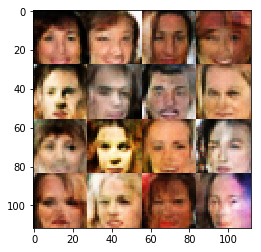

Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.6209
Epoch 1/1... Discriminator Loss: 1.3305... Generator Loss: 0.5494
Epoch 1/1... Discriminator Loss: 1.2196... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.5908
Epoch 1/1... Discriminator Loss: 1.1360... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 1.0309
Epoch 1/1... Discriminator Loss: 1.2798... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.5433
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.5847


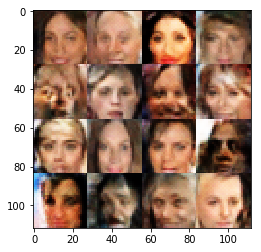

Epoch 1/1... Discriminator Loss: 1.5768... Generator Loss: 0.4760
Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.4970
Epoch 1/1... Discriminator Loss: 1.3254... Generator Loss: 0.6960
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.9665
Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.0729... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.2257... Generator Loss: 1.0910
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 1.0442
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.9223
Epoch 1/1... Discriminator Loss: 1.2289... Generator Loss: 0.8839


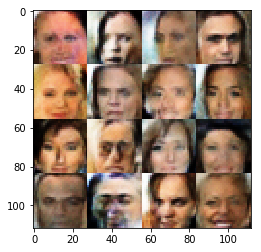

Epoch 1/1... Discriminator Loss: 1.6266... Generator Loss: 0.6393
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.2932... Generator Loss: 0.7636
Epoch 1/1... Discriminator Loss: 1.2854... Generator Loss: 0.7436
Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.8221
Epoch 1/1... Discriminator Loss: 1.3529... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.8841
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.8798
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.7776


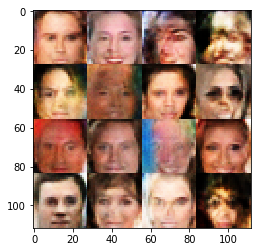

Epoch 1/1... Discriminator Loss: 1.1234... Generator Loss: 0.8229
Epoch 1/1... Discriminator Loss: 1.2957... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.6307
Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.8740
Epoch 1/1... Discriminator Loss: 1.3210... Generator Loss: 0.7825
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.8743
Epoch 1/1... Discriminator Loss: 1.0677... Generator Loss: 1.0939
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.8851
Epoch 1/1... Discriminator Loss: 1.4948... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.1508... Generator Loss: 1.0154


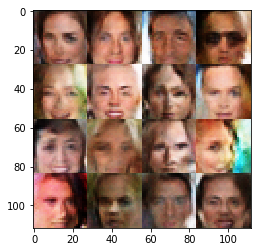

Epoch 1/1... Discriminator Loss: 1.3831... Generator Loss: 0.6852
Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.4918
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.1822... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.2929... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7312
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.1055
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 0.8537
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7809


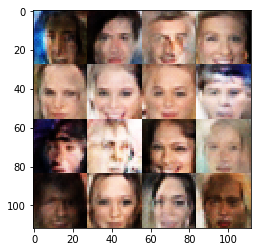

Epoch 1/1... Discriminator Loss: 1.2345... Generator Loss: 0.8883
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.5548
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7247
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.6026
Epoch 1/1... Discriminator Loss: 1.4195... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.7948
Epoch 1/1... Discriminator Loss: 1.3593... Generator Loss: 0.6861
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.6612
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.8411


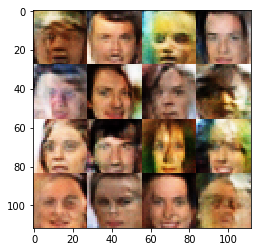

Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 0.5979
Epoch 1/1... Discriminator Loss: 1.2507... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.2062... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 1.0784
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 0.8594
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 0.9233
Epoch 1/1... Discriminator Loss: 1.5184... Generator Loss: 0.5354
Epoch 1/1... Discriminator Loss: 1.0897... Generator Loss: 1.1454
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.5473
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6653


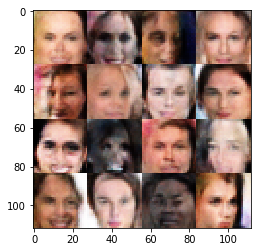

Epoch 1/1... Discriminator Loss: 1.2917... Generator Loss: 0.7068
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.9280
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.8335
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 1.0594
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.6510
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.7638
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8599
Epoch 1/1... Discriminator Loss: 1.2688... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.1931... Generator Loss: 0.8135
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.6332


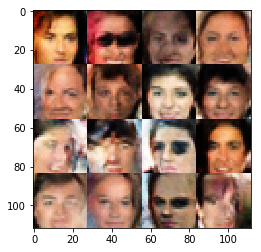

Epoch 1/1... Discriminator Loss: 1.3545... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.3626... Generator Loss: 0.9583
Epoch 1/1... Discriminator Loss: 1.2513... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.2667... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.3237... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.9165
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 1.1835


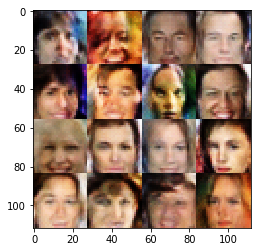

Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.1532... Generator Loss: 0.9022
Epoch 1/1... Discriminator Loss: 1.5161... Generator Loss: 0.5695
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.7748
Epoch 1/1... Discriminator Loss: 1.3446... Generator Loss: 0.6122
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.5701... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.4183... Generator Loss: 0.7076


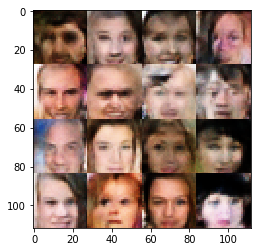

Epoch 1/1... Discriminator Loss: 1.2459... Generator Loss: 0.7850
Epoch 1/1... Discriminator Loss: 1.1094... Generator Loss: 1.0609
Epoch 1/1... Discriminator Loss: 1.1703... Generator Loss: 0.8213
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.4959
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.5848
Epoch 1/1... Discriminator Loss: 1.3748... Generator Loss: 0.6734
Epoch 1/1... Discriminator Loss: 1.3362... Generator Loss: 0.7173
Epoch 1/1... Discriminator Loss: 1.4248... Generator Loss: 0.8572


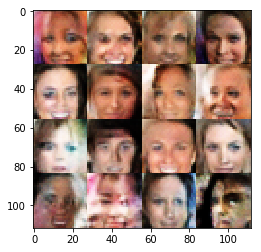

Epoch 1/1... Discriminator Loss: 1.2307... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.3024... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.2308... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.8668
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7007
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.8423
Epoch 1/1... Discriminator Loss: 1.2765... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.1154... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.9207


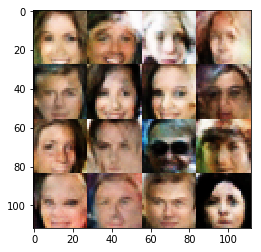

Epoch 1/1... Discriminator Loss: 1.2232... Generator Loss: 0.8650
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 0.9519
Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 0.7424
Epoch 1/1... Discriminator Loss: 1.1938... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.7505
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.3253... Generator Loss: 1.0721
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.9139
Epoch 1/1... Discriminator Loss: 1.2080... Generator Loss: 0.8907


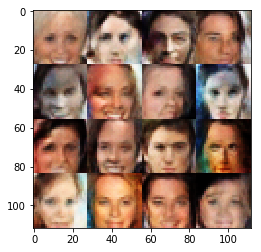

Epoch 1/1... Discriminator Loss: 1.2827... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.3004... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.3235... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.1686... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.1198... Generator Loss: 1.1560
Epoch 1/1... Discriminator Loss: 1.3736... Generator Loss: 0.7431
Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.9049
Epoch 1/1... Discriminator Loss: 1.5313... Generator Loss: 0.4971
Epoch 1/1... Discriminator Loss: 1.1735... Generator Loss: 0.8301


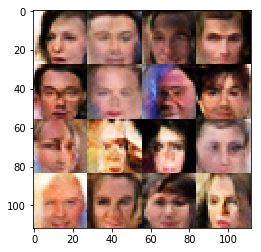

Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 0.9807
Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.8580
Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.3051... Generator Loss: 0.8149
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.9376
Epoch 1/1... Discriminator Loss: 1.2835... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.1243... Generator Loss: 0.9206
Epoch 1/1... Discriminator Loss: 1.2836... Generator Loss: 0.9874
Epoch 1/1... Discriminator Loss: 1.2498... Generator Loss: 0.7310


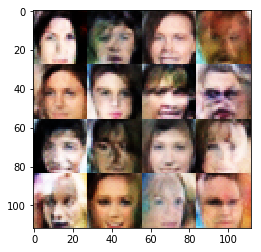

Epoch 1/1... Discriminator Loss: 1.1902... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 0.9962... Generator Loss: 1.1114
Epoch 1/1... Discriminator Loss: 1.3367... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.2804... Generator Loss: 1.1346
Epoch 1/1... Discriminator Loss: 1.2058... Generator Loss: 0.8386
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.6619
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.8304
Epoch 1/1... Discriminator Loss: 1.2086... Generator Loss: 0.9379
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8536
Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7442


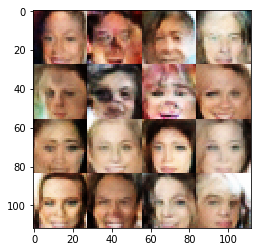

Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 1.1061
Epoch 1/1... Discriminator Loss: 1.2229... Generator Loss: 0.9858
Epoch 1/1... Discriminator Loss: 1.1795... Generator Loss: 1.1126
Epoch 1/1... Discriminator Loss: 1.2403... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 1.2592... Generator Loss: 0.8487
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.2910... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.1677... Generator Loss: 1.0587
Epoch 1/1... Discriminator Loss: 1.3584... Generator Loss: 0.7768


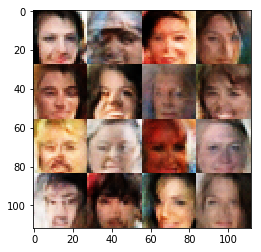

Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 1.2704
Epoch 1/1... Discriminator Loss: 1.3230... Generator Loss: 0.6702
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.5234
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.2673... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.3189... Generator Loss: 0.8372
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.3072... Generator Loss: 0.8828


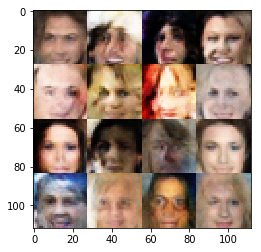

Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 0.9560
Epoch 1/1... Discriminator Loss: 1.1858... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.8623
Epoch 1/1... Discriminator Loss: 1.3935... Generator Loss: 0.8708
Epoch 1/1... Discriminator Loss: 1.4565... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.2898... Generator Loss: 0.7750
Epoch 1/1... Discriminator Loss: 1.2262... Generator Loss: 0.7809
Epoch 1/1... Discriminator Loss: 1.3986... Generator Loss: 0.5735


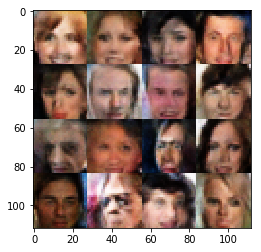

Epoch 1/1... Discriminator Loss: 1.1546... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.2362... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.5733... Generator Loss: 0.6514
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.0394
Epoch 1/1... Discriminator Loss: 1.3464... Generator Loss: 0.5796
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.3841... Generator Loss: 0.5580
Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.8735
Epoch 1/1... Discriminator Loss: 1.5334... Generator Loss: 0.5419


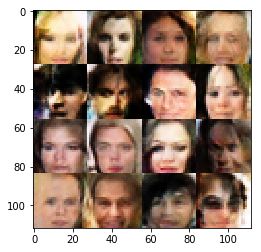

Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8758
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.8633
Epoch 1/1... Discriminator Loss: 1.4602... Generator Loss: 0.6429
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.8331
Epoch 1/1... Discriminator Loss: 1.3244... Generator Loss: 0.7149
Epoch 1/1... Discriminator Loss: 1.3264... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.2485... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 0.7365
Epoch 1/1... Discriminator Loss: 1.2032... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.2346... Generator Loss: 0.7364


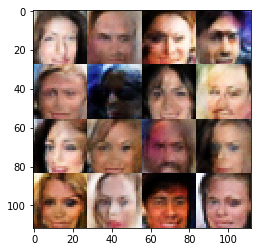

Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3954... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.2911... Generator Loss: 0.8792
Epoch 1/1... Discriminator Loss: 1.3076... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.5109... Generator Loss: 0.6221
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.1807... Generator Loss: 0.9483
Epoch 1/1... Discriminator Loss: 1.2860... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.8587
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.6346


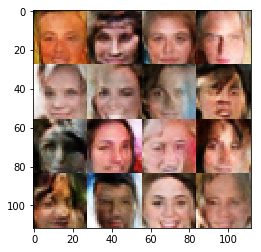

Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.9044
Epoch 1/1... Discriminator Loss: 1.3263... Generator Loss: 0.9006
Epoch 1/1... Discriminator Loss: 1.2651... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.2488... Generator Loss: 0.6752
Epoch 1/1... Discriminator Loss: 1.3293... Generator Loss: 1.0627
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8781
Epoch 1/1... Discriminator Loss: 1.2805... Generator Loss: 0.7064
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.1556
Epoch 1/1... Discriminator Loss: 1.1454... Generator Loss: 1.0246
Epoch 1/1... Discriminator Loss: 1.2414... Generator Loss: 0.9372


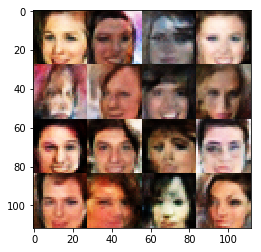

Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 1.0023
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.6006
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.6617
Epoch 1/1... Discriminator Loss: 1.1765... Generator Loss: 0.8311
Epoch 1/1... Discriminator Loss: 1.4005... Generator Loss: 0.5961
Epoch 1/1... Discriminator Loss: 1.3717... Generator Loss: 0.4961
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.5997
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7329
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.5193


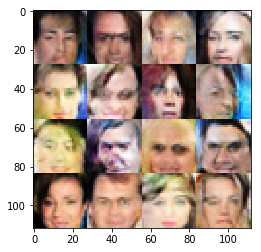

Epoch 1/1... Discriminator Loss: 1.2405... Generator Loss: 0.8665
Epoch 1/1... Discriminator Loss: 1.2649... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4595... Generator Loss: 0.6476
Epoch 1/1... Discriminator Loss: 1.0779... Generator Loss: 1.1285
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.2889... Generator Loss: 0.8089
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.2782... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.1131... Generator Loss: 0.9683
Epoch 1/1... Discriminator Loss: 1.3527... Generator Loss: 0.6155


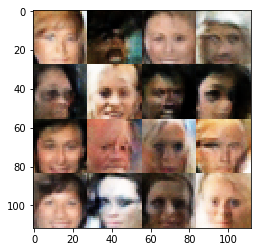

Epoch 1/1... Discriminator Loss: 1.0955... Generator Loss: 0.9254
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 1.0094
Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 1.0514
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.6746
Epoch 1/1... Discriminator Loss: 1.2504... Generator Loss: 0.7828
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8099
Epoch 1/1... Discriminator Loss: 1.0627... Generator Loss: 0.9848
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 0.8044


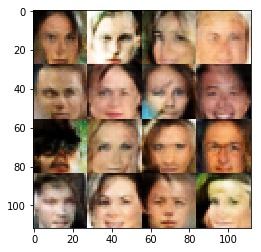

Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.8155
Epoch 1/1... Discriminator Loss: 1.4157... Generator Loss: 0.6919
Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.4841... Generator Loss: 0.5742
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5767
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 1.0271
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 1.0056
Epoch 1/1... Discriminator Loss: 1.3439... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.8082


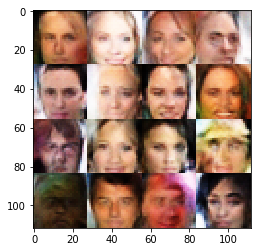

Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.6969
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.5518
Epoch 1/1... Discriminator Loss: 1.2267... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 1.3389... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.3012... Generator Loss: 0.7069
Epoch 1/1... Discriminator Loss: 1.1354... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.2152... Generator Loss: 0.8291
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7139
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.8486
Epoch 1/1... Discriminator Loss: 1.3285... Generator Loss: 0.7736


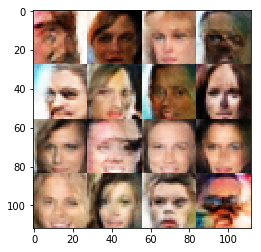

Epoch 1/1... Discriminator Loss: 1.3592... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.3366... Generator Loss: 0.6655
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.8827
Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.3331... Generator Loss: 0.7592
Epoch 1/1... Discriminator Loss: 1.1982... Generator Loss: 0.8575
Epoch 1/1... Discriminator Loss: 1.2526... Generator Loss: 0.7927


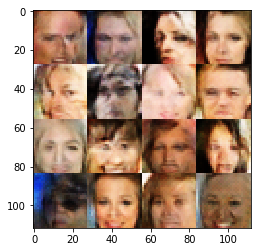

Epoch 1/1... Discriminator Loss: 1.3687... Generator Loss: 0.7963
Epoch 1/1... Discriminator Loss: 1.3868... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.6675
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 0.8297
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.6990
Epoch 1/1... Discriminator Loss: 1.1163... Generator Loss: 1.0011
Epoch 1/1... Discriminator Loss: 1.1935... Generator Loss: 0.8538
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7514
Epoch 1/1... Discriminator Loss: 1.2248... Generator Loss: 0.7923
Epoch 1/1... Discriminator Loss: 1.2656... Generator Loss: 0.6563


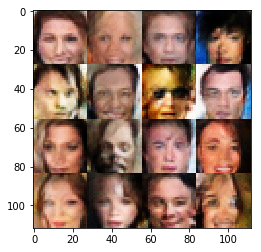

Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.7298
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6941
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.2225... Generator Loss: 0.8904
Epoch 1/1... Discriminator Loss: 1.5382... Generator Loss: 0.5851
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 0.8299
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.2608... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.3739... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.1619... Generator Loss: 0.8605


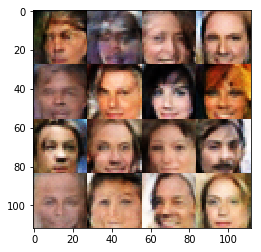

Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.2751... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.6863
Epoch 1/1... Discriminator Loss: 1.4524... Generator Loss: 0.7158
Epoch 1/1... Discriminator Loss: 1.2924... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.3567... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.3089... Generator Loss: 0.6575
Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.9410
Epoch 1/1... Discriminator Loss: 1.1632... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3107... Generator Loss: 0.7248


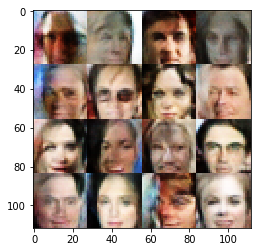

Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.8711
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.8579
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3484... Generator Loss: 0.9465
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.2790... Generator Loss: 0.7585
Epoch 1/1... Discriminator Loss: 1.2781... Generator Loss: 0.8209
Epoch 1/1... Discriminator Loss: 1.1363... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.8219


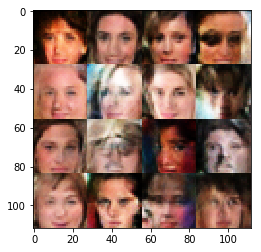

Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.1929... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.5090... Generator Loss: 0.4753
Epoch 1/1... Discriminator Loss: 1.2858... Generator Loss: 0.8084
Epoch 1/1... Discriminator Loss: 1.3661... Generator Loss: 0.5935
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8793
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8528
Epoch 1/1... Discriminator Loss: 1.3509... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.0381


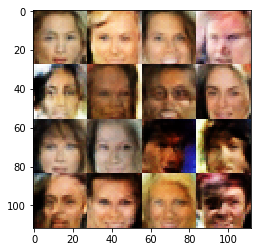

Epoch 1/1... Discriminator Loss: 1.2240... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.0504... Generator Loss: 1.1036
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 1.0359
Epoch 1/1... Discriminator Loss: 1.3595... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.1709... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.3312... Generator Loss: 0.7496
Epoch 1/1... Discriminator Loss: 1.2324... Generator Loss: 0.8637


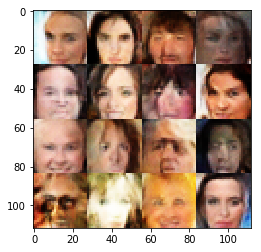

Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.6294
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 1.4403... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.1560... Generator Loss: 0.8950
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.6723
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.8696
Epoch 1/1... Discriminator Loss: 1.1242... Generator Loss: 1.1465
Epoch 1/1... Discriminator Loss: 1.2021... Generator Loss: 0.8277
Epoch 1/1... Discriminator Loss: 1.3778... Generator Loss: 0.6191


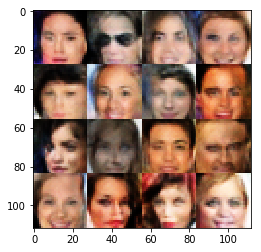

Epoch 1/1... Discriminator Loss: 1.1761... Generator Loss: 0.8837
Epoch 1/1... Discriminator Loss: 1.6330... Generator Loss: 0.4340
Epoch 1/1... Discriminator Loss: 1.4803... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.3641... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4921... Generator Loss: 0.5491
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 0.7513


In [28]:
batch_size = 16
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.